# COVID X-ray Classification using Logistic Regression

X-ray dataset used: https://www.kaggle.com/datasets/ahemateja19bec1025/covid-xray-dataset

In [1]:
# Make necessary imports

from PIL import Image, ImageEnhance, ImageDraw
import numpy as np
from random import shuffle
from IPython.core.display import HTML
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import base64
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from seaborn import heatmap, countplot

red = (255, 0, 0)
black = (0, 0, 0)
grey = (128, 128, 128)
white = (255, 255, 255)
segmented_colors = [black, grey, white]
indices = {black: 0, grey: 1, white: 2}
contrast_factor = 3

In [2]:
def img_to_base64(img):
    buffer = BytesIO()
    img.save(buffer, format="JPEG")
    return "data:image/jpeg;base64,"+base64.b64encode(buffer.getvalue()).decode()

In [3]:
# Function to display colors

def display_colors(colors):
    s=''
    for color in colors:
        s+=f'<div style="background-color:rgb({int(color[0])},{int(color[1])},{int(color[2])}); display:inline-block; margin:2px; border:2px solid #888; height:50px; width:50px;"></div>'
    display(HTML(s))
    
def display_images(images):
    s=''
    for image in images:
        s+=f'<img src="{img_to_base64(image)}" style="width:200px; object-fit:contain; display:inline-block; margin:1px;">'
    display(HTML(s))

display_colors([red, black, grey, white])

In [4]:
def counter(img, d):
    arr = np.asarray(img)
    arr = arr.reshape(-1, arr.shape[-1])
    unique, counts = np.unique(arr, return_counts=True, axis=0)
    ct = {}
    for p, c in zip(unique, counts):
        p = tuple(p)
        if p in d: ct[d[p]] = c
    return ct

def get_ratios(b):
    bc = np.asarray([b.get(i, 0) for i in range(3)])
    return bc/bc.sum()

In [5]:
def posterize(image, colors):
    img = np.asarray(image).copy()
    s = img.shape
    img1 = img.reshape(-1, s[-1])
    eds = []
    for p in colors:
        t = np.sum((img1-p)**2, axis=1)
        eds.append(t)
    ed = np.asarray(tuple(eds)).T
    im = ed.argmin(axis=1)
    for i, p in enumerate(colors): img1[im==i] = p
    return Image.fromarray(img1.reshape(s))

In [6]:
def trim(img, target_color, replace_color):
    arr = np.asarray(img)
    s = arr.shape
    for i in range(s[0]):
        if (arr[i][0]==target_color).all():
            ImageDraw.floodfill(img, (0, i), replace_color)
            arr = np.asarray(img)
        if (arr[i][s[1]-1]==target_color).all():
            ImageDraw.floodfill(img, (s[1]-1, i), replace_color)
            arr = np.asarray(img)
    for i in range(s[1]):
        if (arr[0][i]==target_color).all():
            ImageDraw.floodfill(img, (i, 0), replace_color)   
            arr = np.asarray(img)
        if (arr[s[0]-1][i]==target_color).all():
            ImageDraw.floodfill(img, (i, s[0]-1), replace_color)
            arr = np.asarray(img)

In [7]:
def get_features(image_path, cf=contrast_factor):
    image = Image.open(image_path)
    imgs = [image.copy()]
    image = ImageEnhance.Contrast(image).enhance(cf)
    imgs.append(image.copy())
    image = posterize(image, segmented_colors)
    imgs.append(image.copy())
    trim(image, black, red)
    imgs.append(image.copy())
    b = counter(image, indices)
    rb = get_ratios(b)
    print(b, rb)
    display_images(imgs)
    return rb

COVID Negative X-Ray Example
{0: 283112, 1: 550921, 2: 827925} [0.17034847 0.33148912 0.49816241]



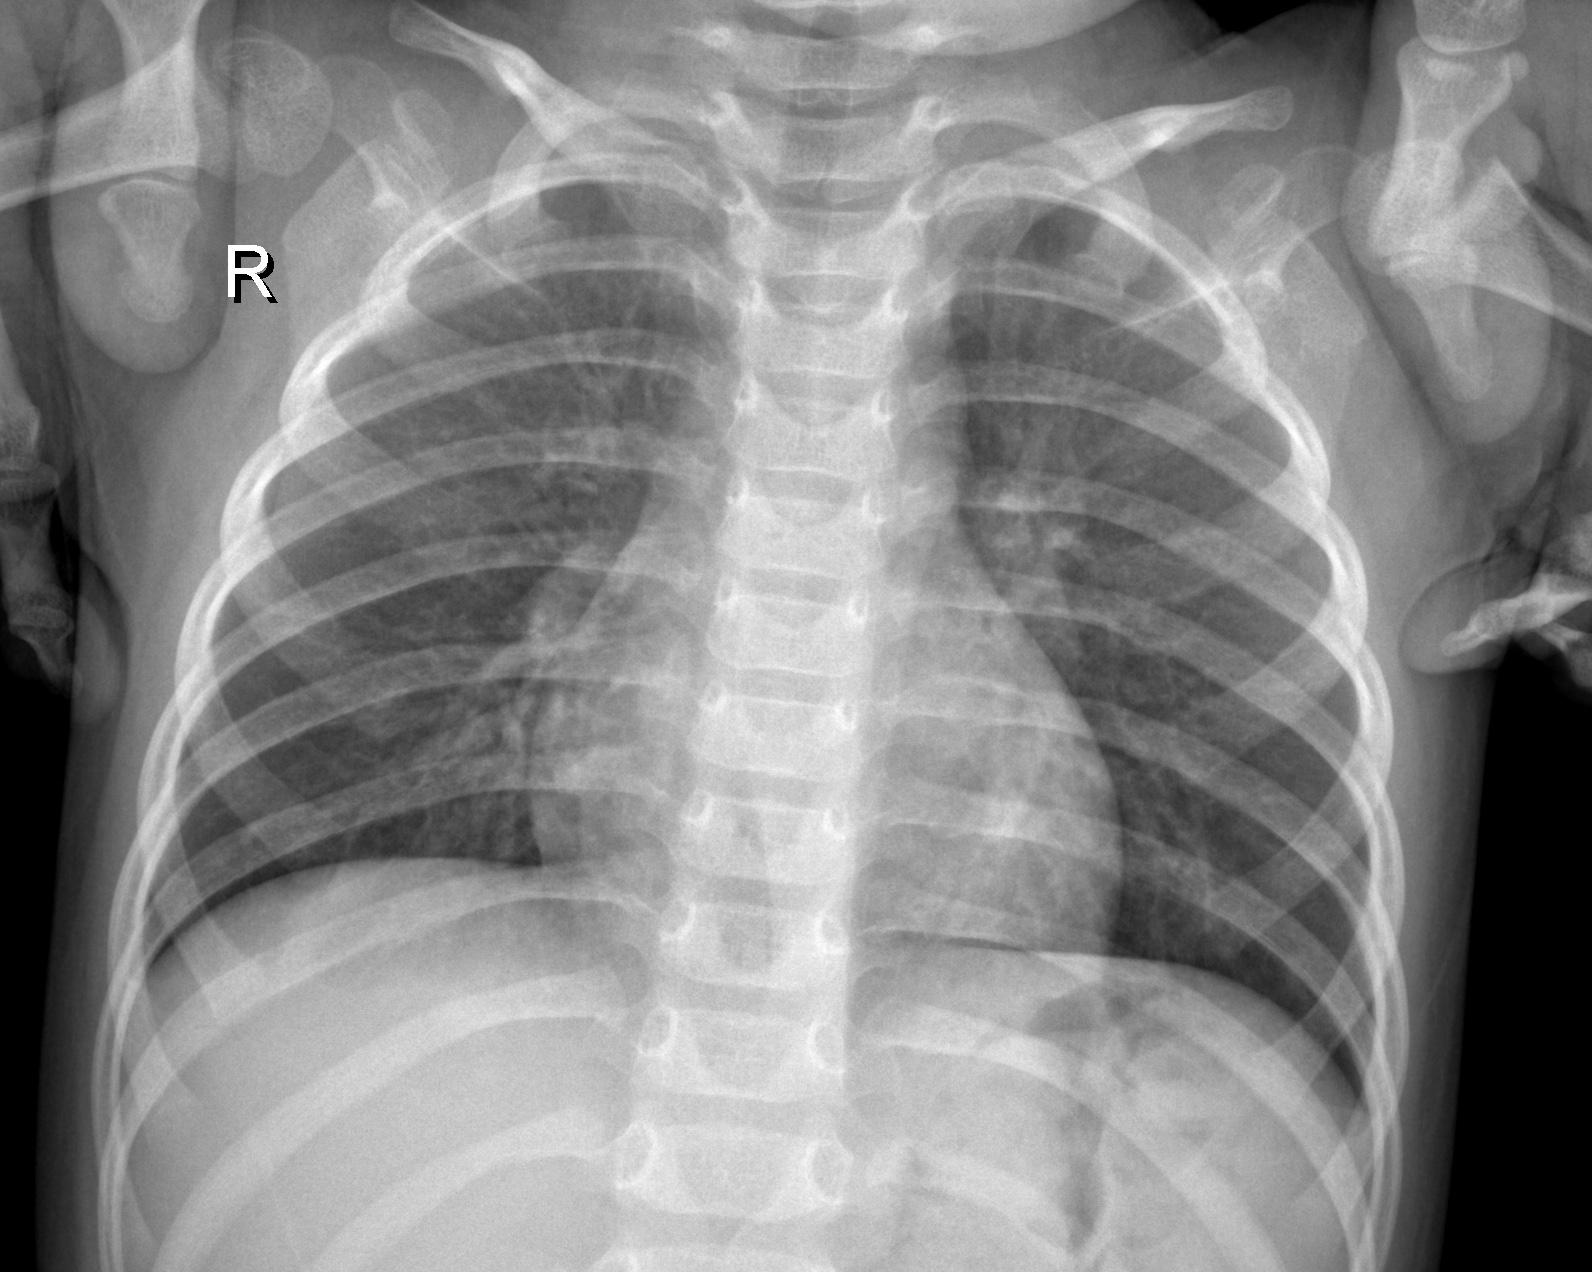
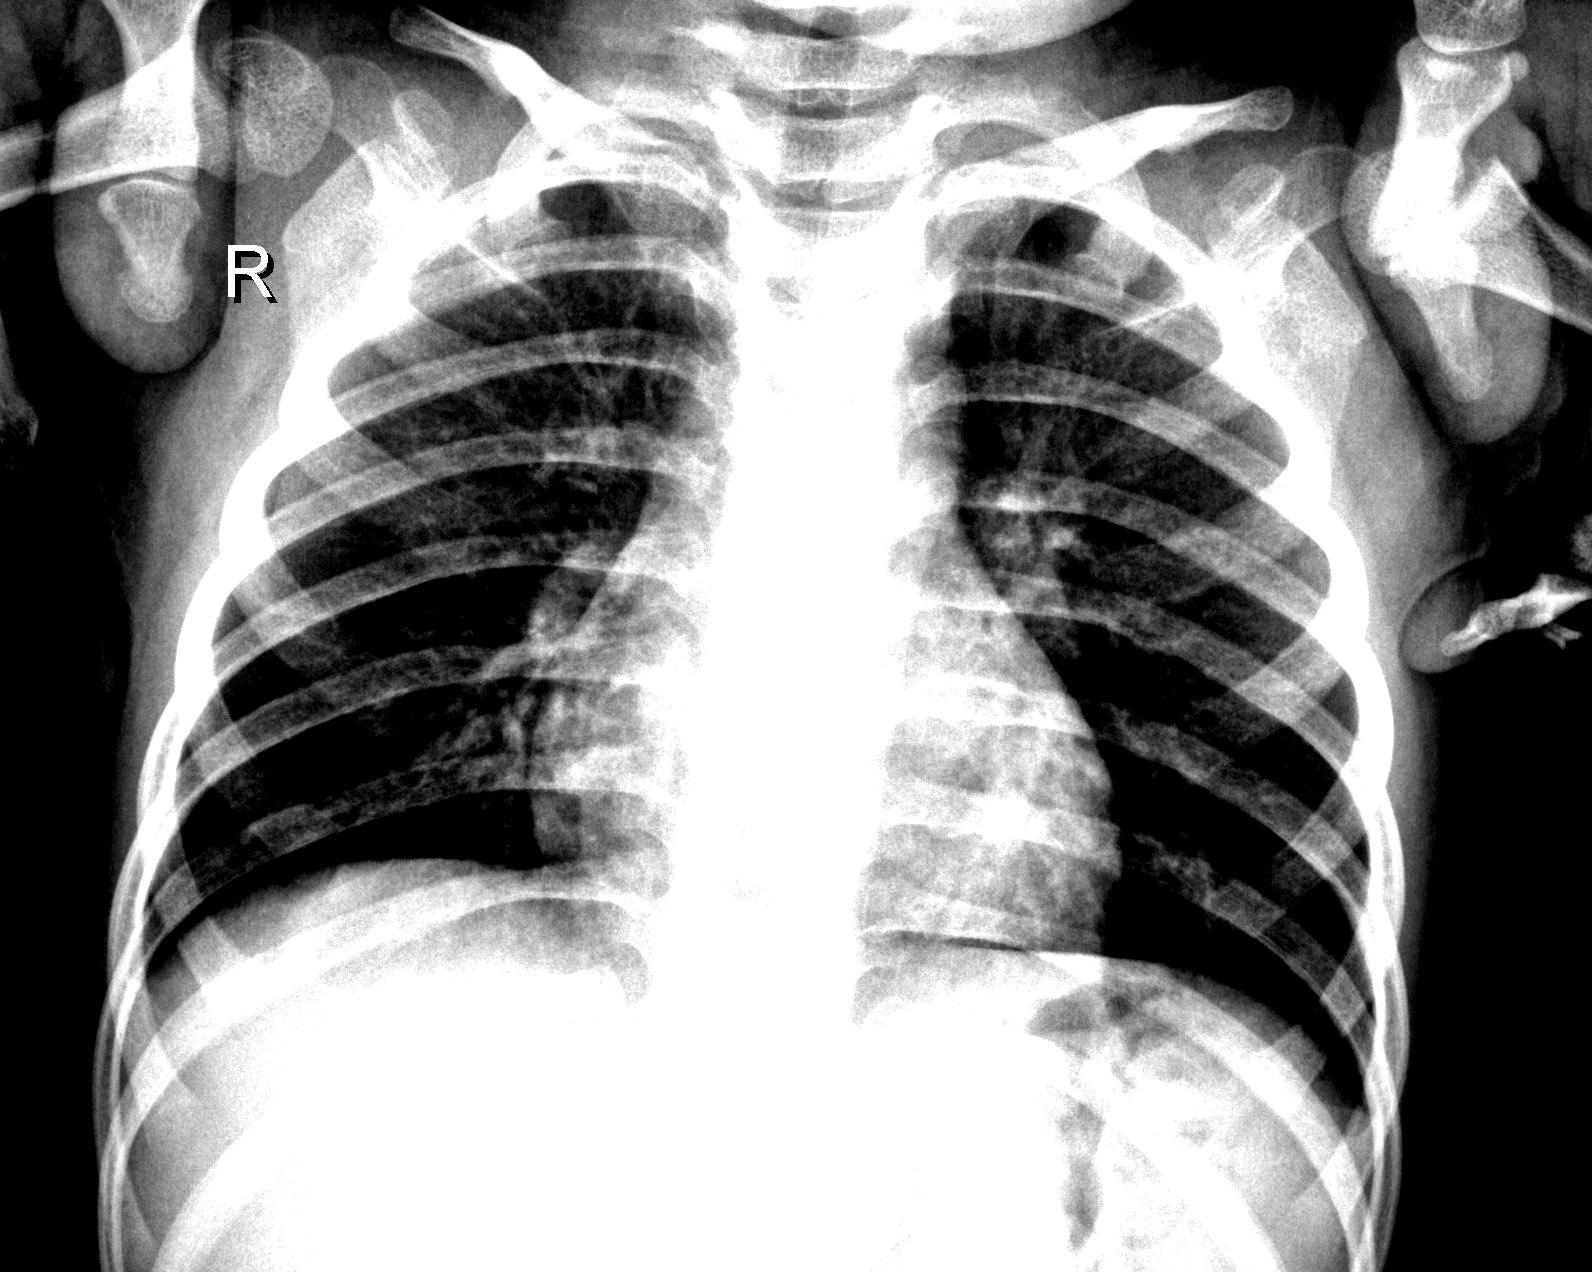
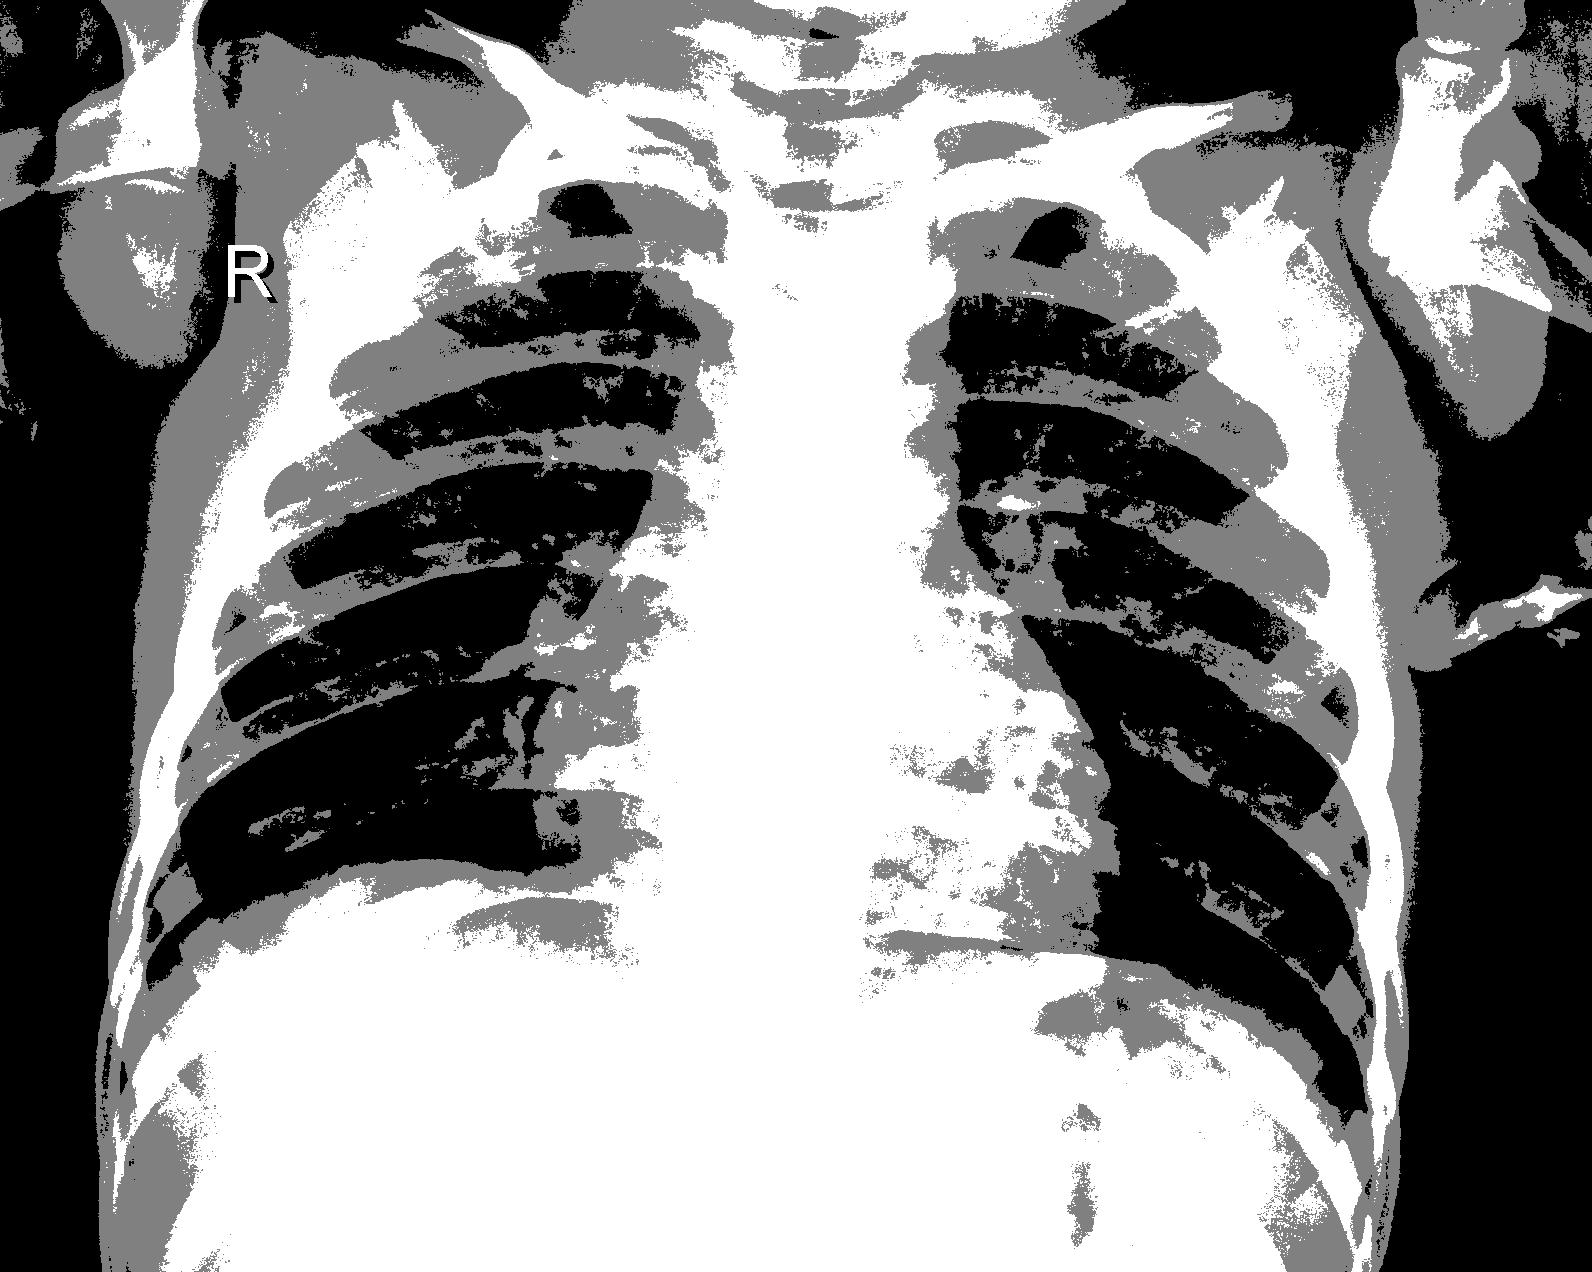
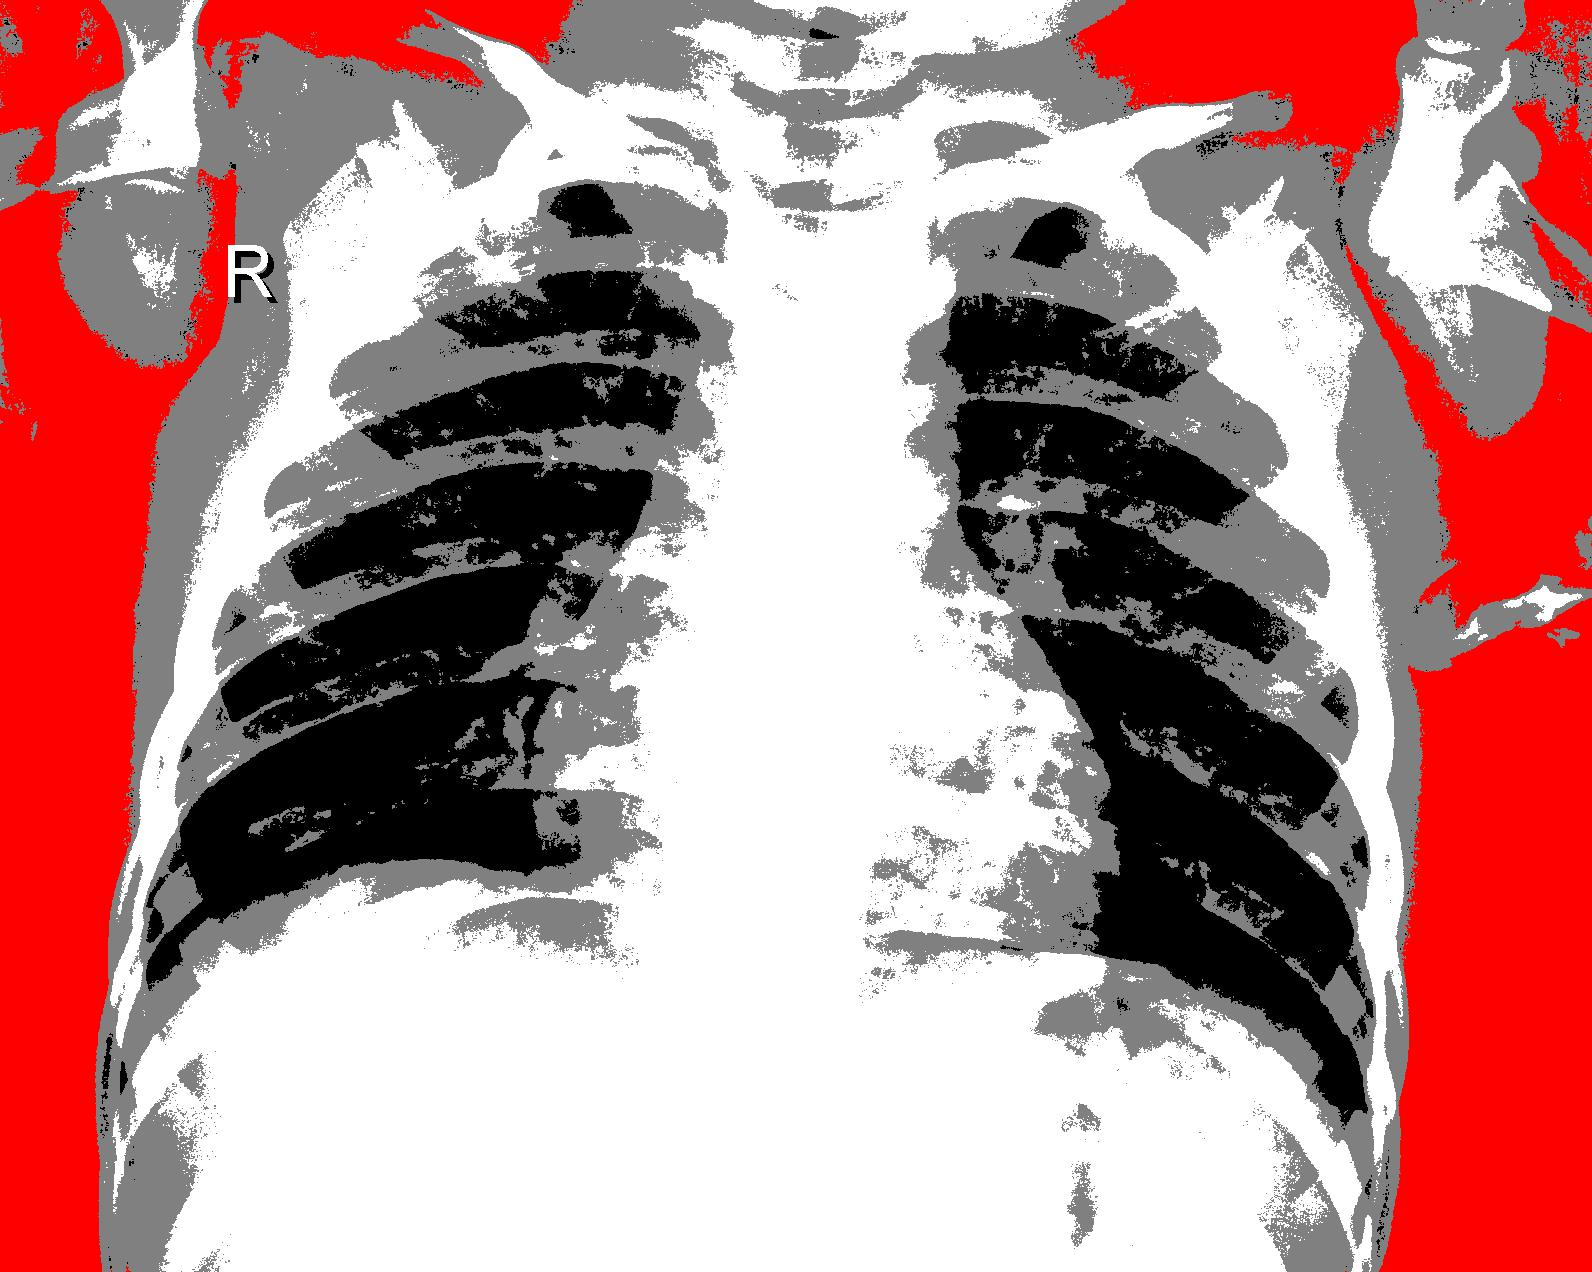


COVID Positive X-Ray Example
{0: 20835, 1: 277654, 2: 528952} [0.02518004 0.33555746 0.6392625 ]



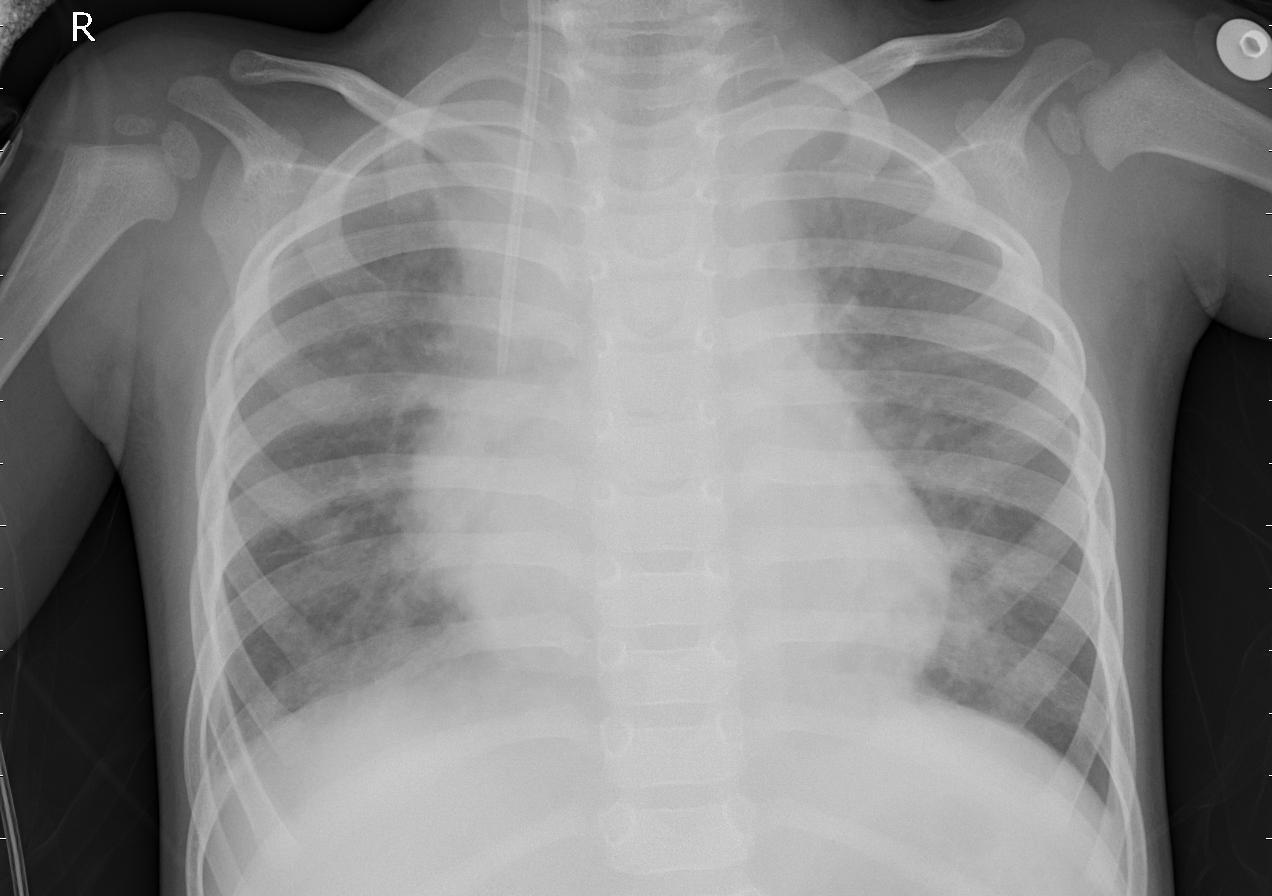
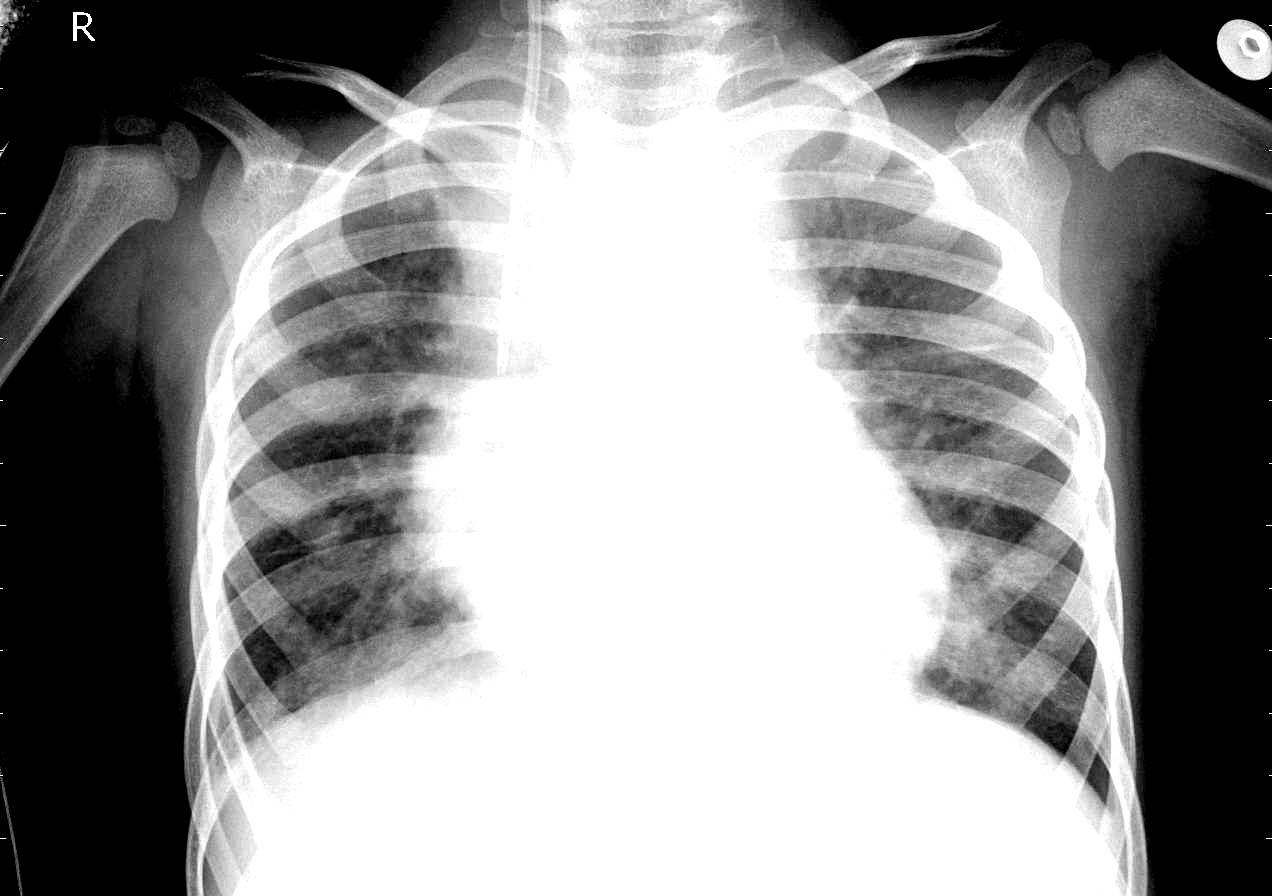
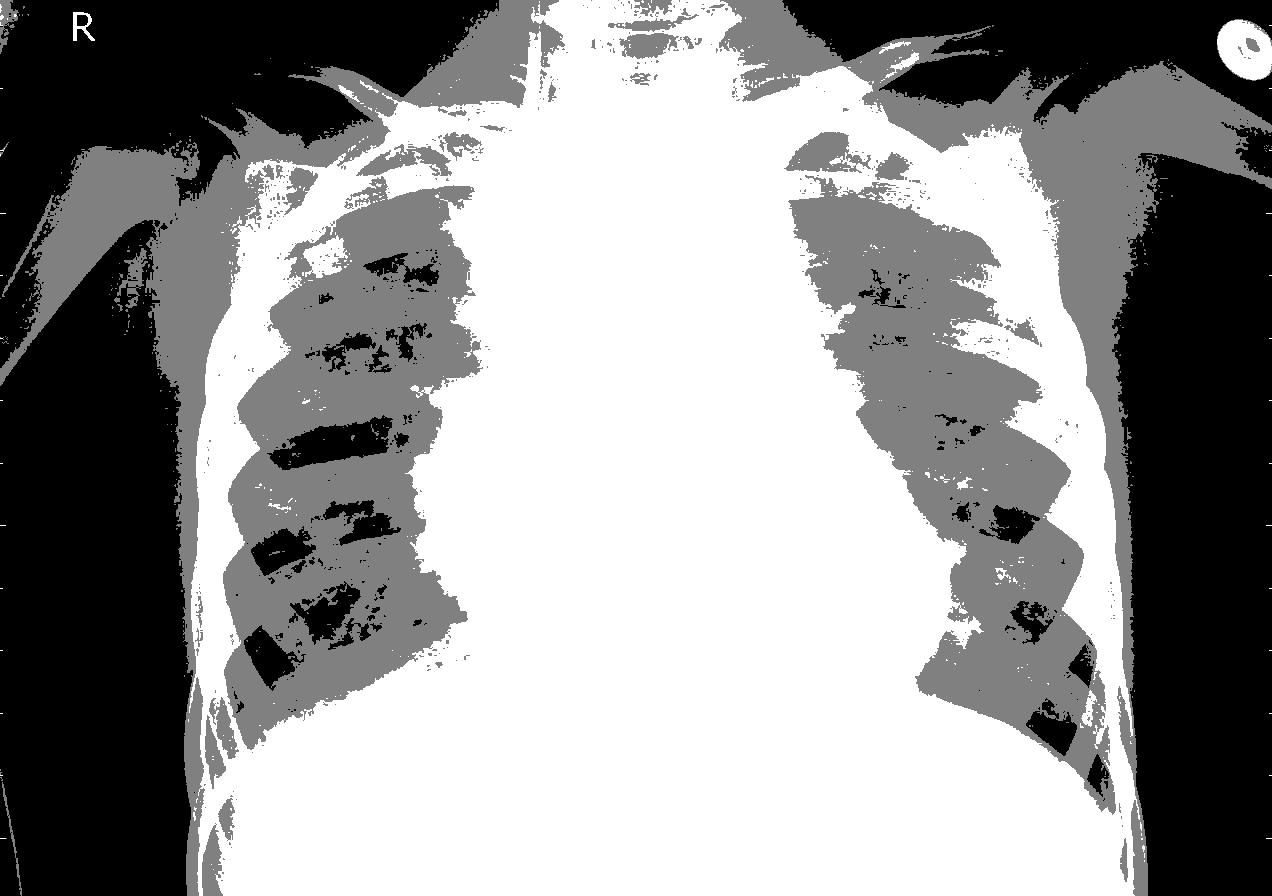
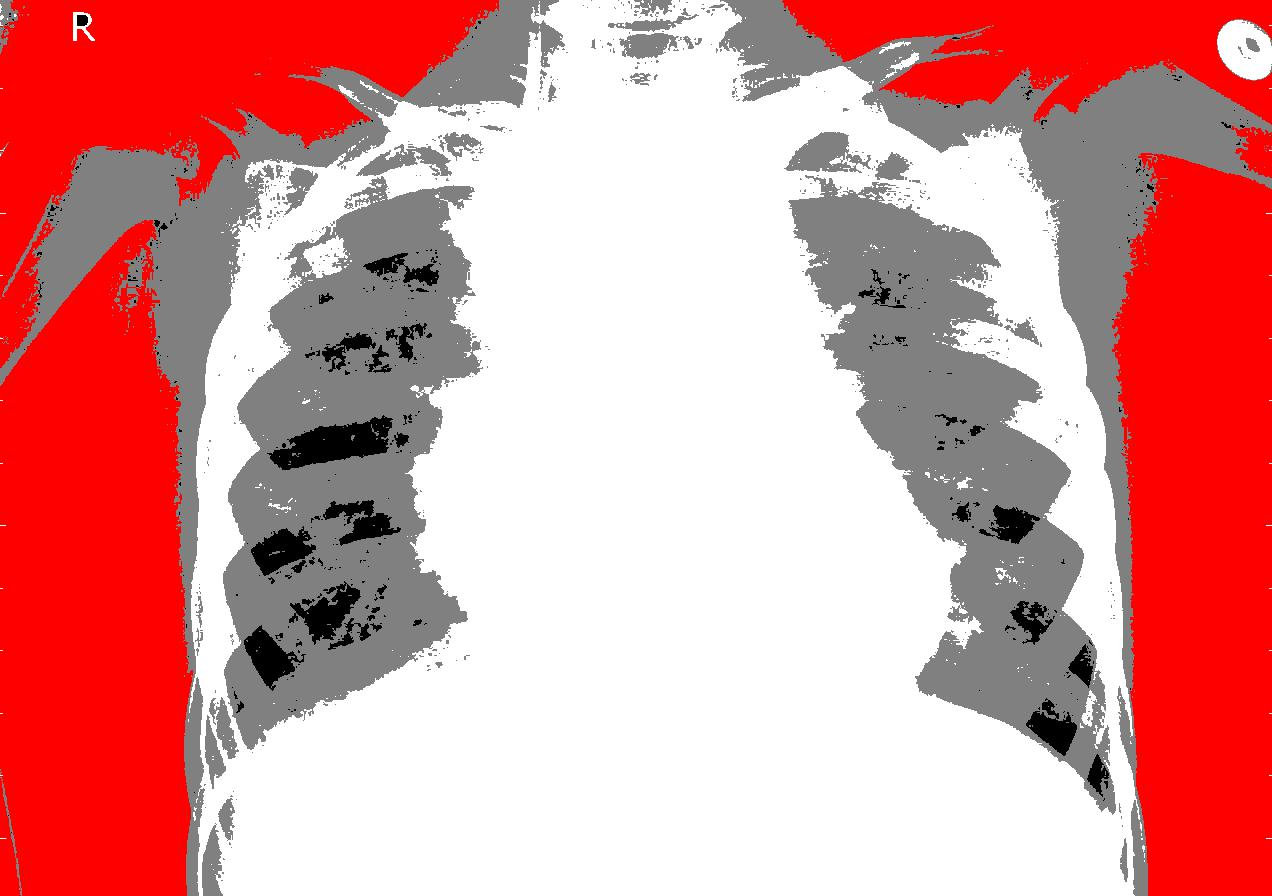

In [8]:
print('COVID Negative X-Ray Example')
get_features(f'D:/DATA/0/normal (56).jpeg')
print('\nCOVID Positive X-Ray Example')
get_features(f'D:/DATA/1/covid (56).jpeg')
print()

### Feature extraction from X-ray images dataset

In [ ]:
# Feature extraction from COVID Negative x-ray samples

neg_data = []
for i in tqdm(range(1, 1302)):
    image = Image.open(f'D:/DATA/0/normal ({i}).jpeg')
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    image = posterize(image, segmented_colors)
    trim(image, black, red)
    counts = counter(image, indices)
    features = get_ratios(counts)
    neg_data.append(features)
    # image.save(f'D:/DATA/Processed/0/normal ({i}).jpeg')

In [ ]:
# Feature extraction from COVID Positive x-ray samples

pos_data = []
for i in tqdm(range(1, 1791)):
    image = Image.open(f'D:/DATA/1/covid ({i}).jpeg')
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    image = posterize(image, segmented_colors)
    trim(image, black, red)
    counts = counter(image, indices)
    features = get_ratios(counts)
    pos_data.append(features)
    # image.save(f'D:/DATA/Processed/1/covid ({i}).jpeg')

In [ ]:
# Saving feature and target data into a CSV file

data = []
s = ''
for v in neg_data:
    v = list(v)
    data.append(v+[0])
    s+= ','.join(map(str, v)) + ',0\n'
for v in pos_data:
    data.append(list(v)+[1])
    s+= ','.join(map(str, v)) + ',1\n'
with open('D:/DATA/covid-xray-features.csv', 'w') as f:
    f.write(s)
shuffle(data)

In [24]:
# Loading data from CSV file
# Run this if Features are already extracted

with open('D:/DATA/covid-xray-features.csv', 'r') as f:
    s = f.read()
neg_data = []
pos_data = []
data = []
for l in s.splitlines():
    datum = list(map(float, l.split(',')))
    data.append(datum)
    if datum[-1]==0: neg_data.append(datum)
    else: pos_data.append(datum)
shuffle(data)

In [25]:
d = np.asarray(data)
X, y = d[:,:3], d[:,3]
print(X, y)

[[0.1154207  0.27509745 0.60948185]
 [0.18071734 0.267824   0.55145865]
 [0.23153855 0.25279536 0.51566609]
 ...
 [0.09843041 0.30083303 0.60073656]
 [0.20835874 0.28684886 0.50479239]
 [0.06004475 0.450262   0.48969325]] [0. 0. 0. ... 0. 0. 1.]


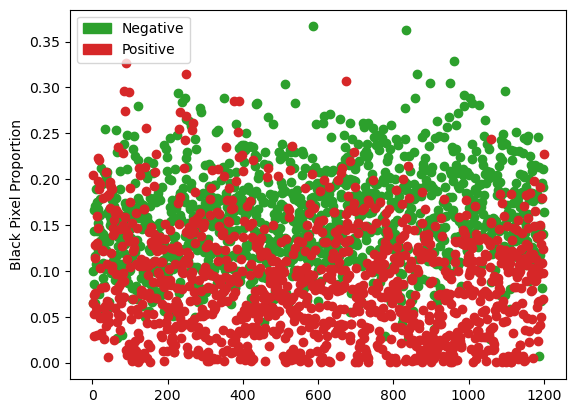

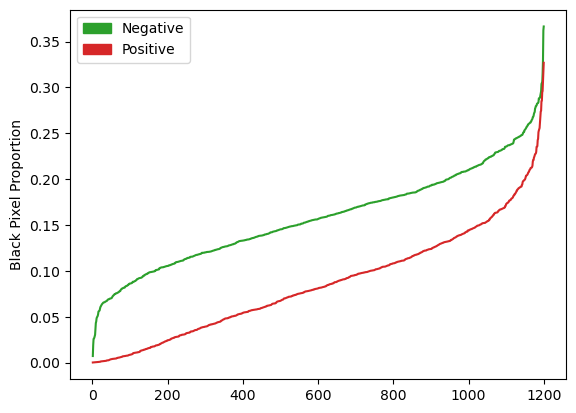

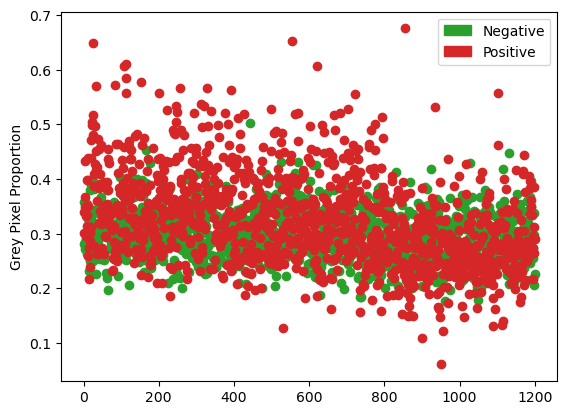

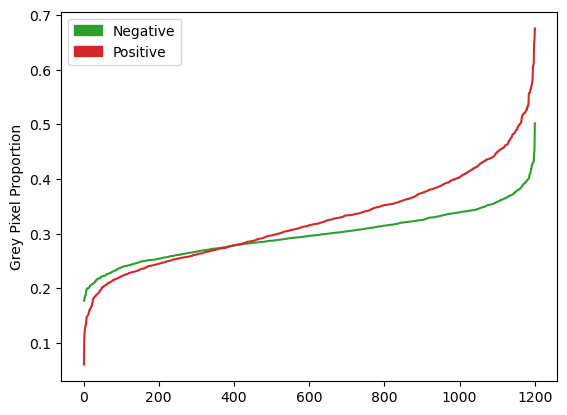

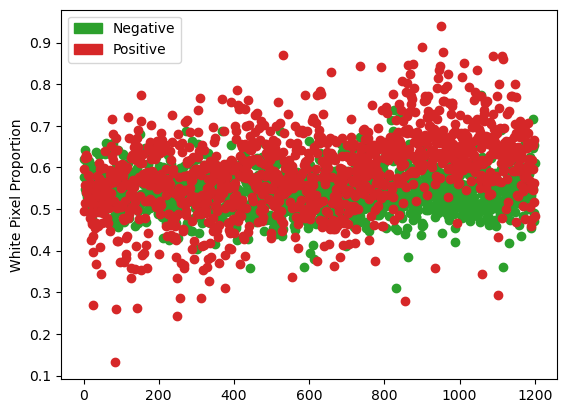

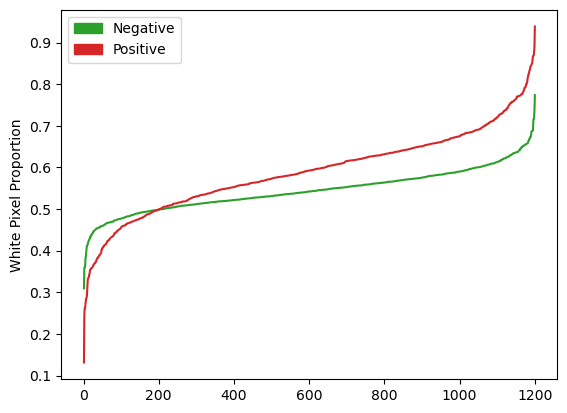

In [26]:
upto = 1200
pop_a = mpatches.Patch(color='tab:green', label='Negative')
pop_b = mpatches.Patch(color='tab:red', label='Positive')
for i, c in enumerate(['Black', 'Grey', 'White']):
    a = np.asarray(neg_data)[:upto, i]
    b = np.asarray(pos_data)[:upto, i]
    plt.scatter(range(1, upto+1), a, color = 'tab:green') 
    plt.scatter(range(1, upto+1), b, color = 'tab:red')
    plt.legend(handles=[pop_a, pop_b])
    plt.ylabel(f'{c} Pixel Proportion')
    plt.show()
    plt.plot(range(1, upto+1), sorted(a), color = 'tab:green') 
    plt.plot(range(1, upto+1), sorted(b), color = 'tab:red')
    plt.legend(handles=[pop_a, pop_b])
    plt.ylabel(f'{c} Pixel Proportion')
    plt.show()

In [27]:
# Split dataset for training & testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=120)

In [28]:
print('Size of Training set:', len(X_train))
print('Size of Testing set:', len(X_test))

Size of Training set: 2163
Size of Testing set: 928


### Custom Implementation

In [43]:
class LogisticRegressionModel():
    def __init__(self, X, y, learning_rate, iterations):      
        self.learning_rate = learning_rate
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.y = y
        for i in range(iterations):
            self.update_weights()
            
    def update_weights(self) :           
        a = 1/(1+np.exp(-(self.X.dot(self.W)+self.b))) 
        dz = a - self.y.T        
        dz = np.reshape(dz, self.m)        
        dW = np.dot(self.X.T, dz)/self.m         
        db = np.sum(dz)/self.m
        self.W = self.W - self.learning_rate * dW    
        self.b = self.b - self.learning_rate * db
    
    def predict(self, X):
        Z = 1/(1 + np.exp(-(X.dot(self.W)+self.b)))        
        y = np.where(Z > 0.5, 1, 0)
        return y

In [49]:
model = LogisticRegressionModel(X_train, y_train, learning_rate = 0.2, iterations = 10000)
print('Weights:', model.W)
y_pred = model.predict(X_test)

Weights: [-13.12269099   5.54843615   4.91492601]


Accuracy: 0.7510775862068966

Classification Report:

               precision    recall  f1-score   support

         0.0       0.71      0.66      0.68       379
         1.0       0.78      0.82      0.80       549

    accuracy                           0.75       928
   macro avg       0.74      0.74      0.74       928
weighted avg       0.75      0.75      0.75       928



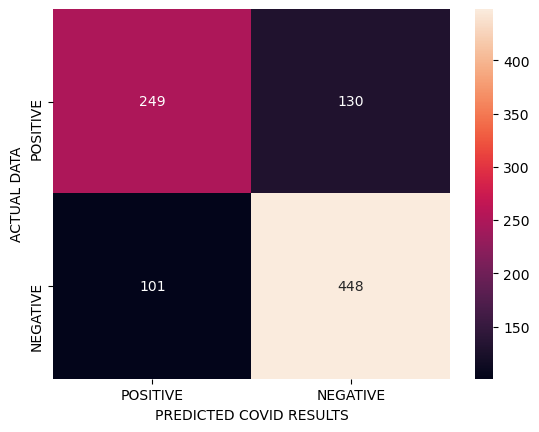

In [50]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n\n', classification_report(y_test, y_pred))
c_m = confusion_matrix(y_test, y_pred)
target_names = ['POSITIVE', 'NEGATIVE']
h_m = heatmap(data=c_m, annot=True, fmt='g', xticklabels=target_names, yticklabels=target_names)
h_m.set(xlabel='PREDICTED COVID RESULTS', ylabel='ACTUAL DATA')
h_m
plt.show()

### Sklearn

In [33]:
clf = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy: 0.7510775862068966

Classification Report:

               precision    recall  f1-score   support

         0.0       0.72      0.63      0.68       379
         1.0       0.77      0.83      0.80       549

    accuracy                           0.75       928
   macro avg       0.74      0.73      0.74       928
weighted avg       0.75      0.75      0.75       928



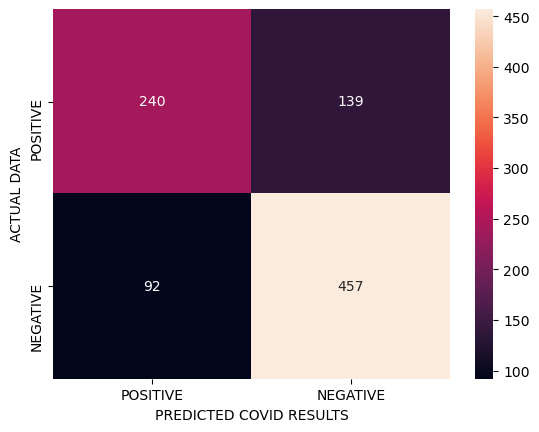

In [34]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n\n', classification_report(y_test, y_pred))
c_m = confusion_matrix(y_test, y_pred)
target_names = ['POSITIVE', 'NEGATIVE']
h_m = heatmap(data=c_m, annot=True, fmt='g', xticklabels=target_names, yticklabels=target_names)
h_m.set(xlabel='PREDICTED COVID RESULTS', ylabel='ACTUAL DATA')
h_m
plt.show()

In [35]:
def predict_from_image(image_path, sklearn_model, custom_model, target_classes):
    features = np.asarray([get_features(image_path)])
    res = sklearn_model.predict(features)[0]
    print('SKLearn model result:', target_classes[int(res)])
    res = custom_model.predict(features)[0]
    print('Custom model result:', target_classes[int(res)])

Test with train & test excluded samples

Testing a COVID Negative X-Ray image
{0: 965031, 1: 1286742, 2: 1680078} [0.24543936 0.32726113 0.42729951]



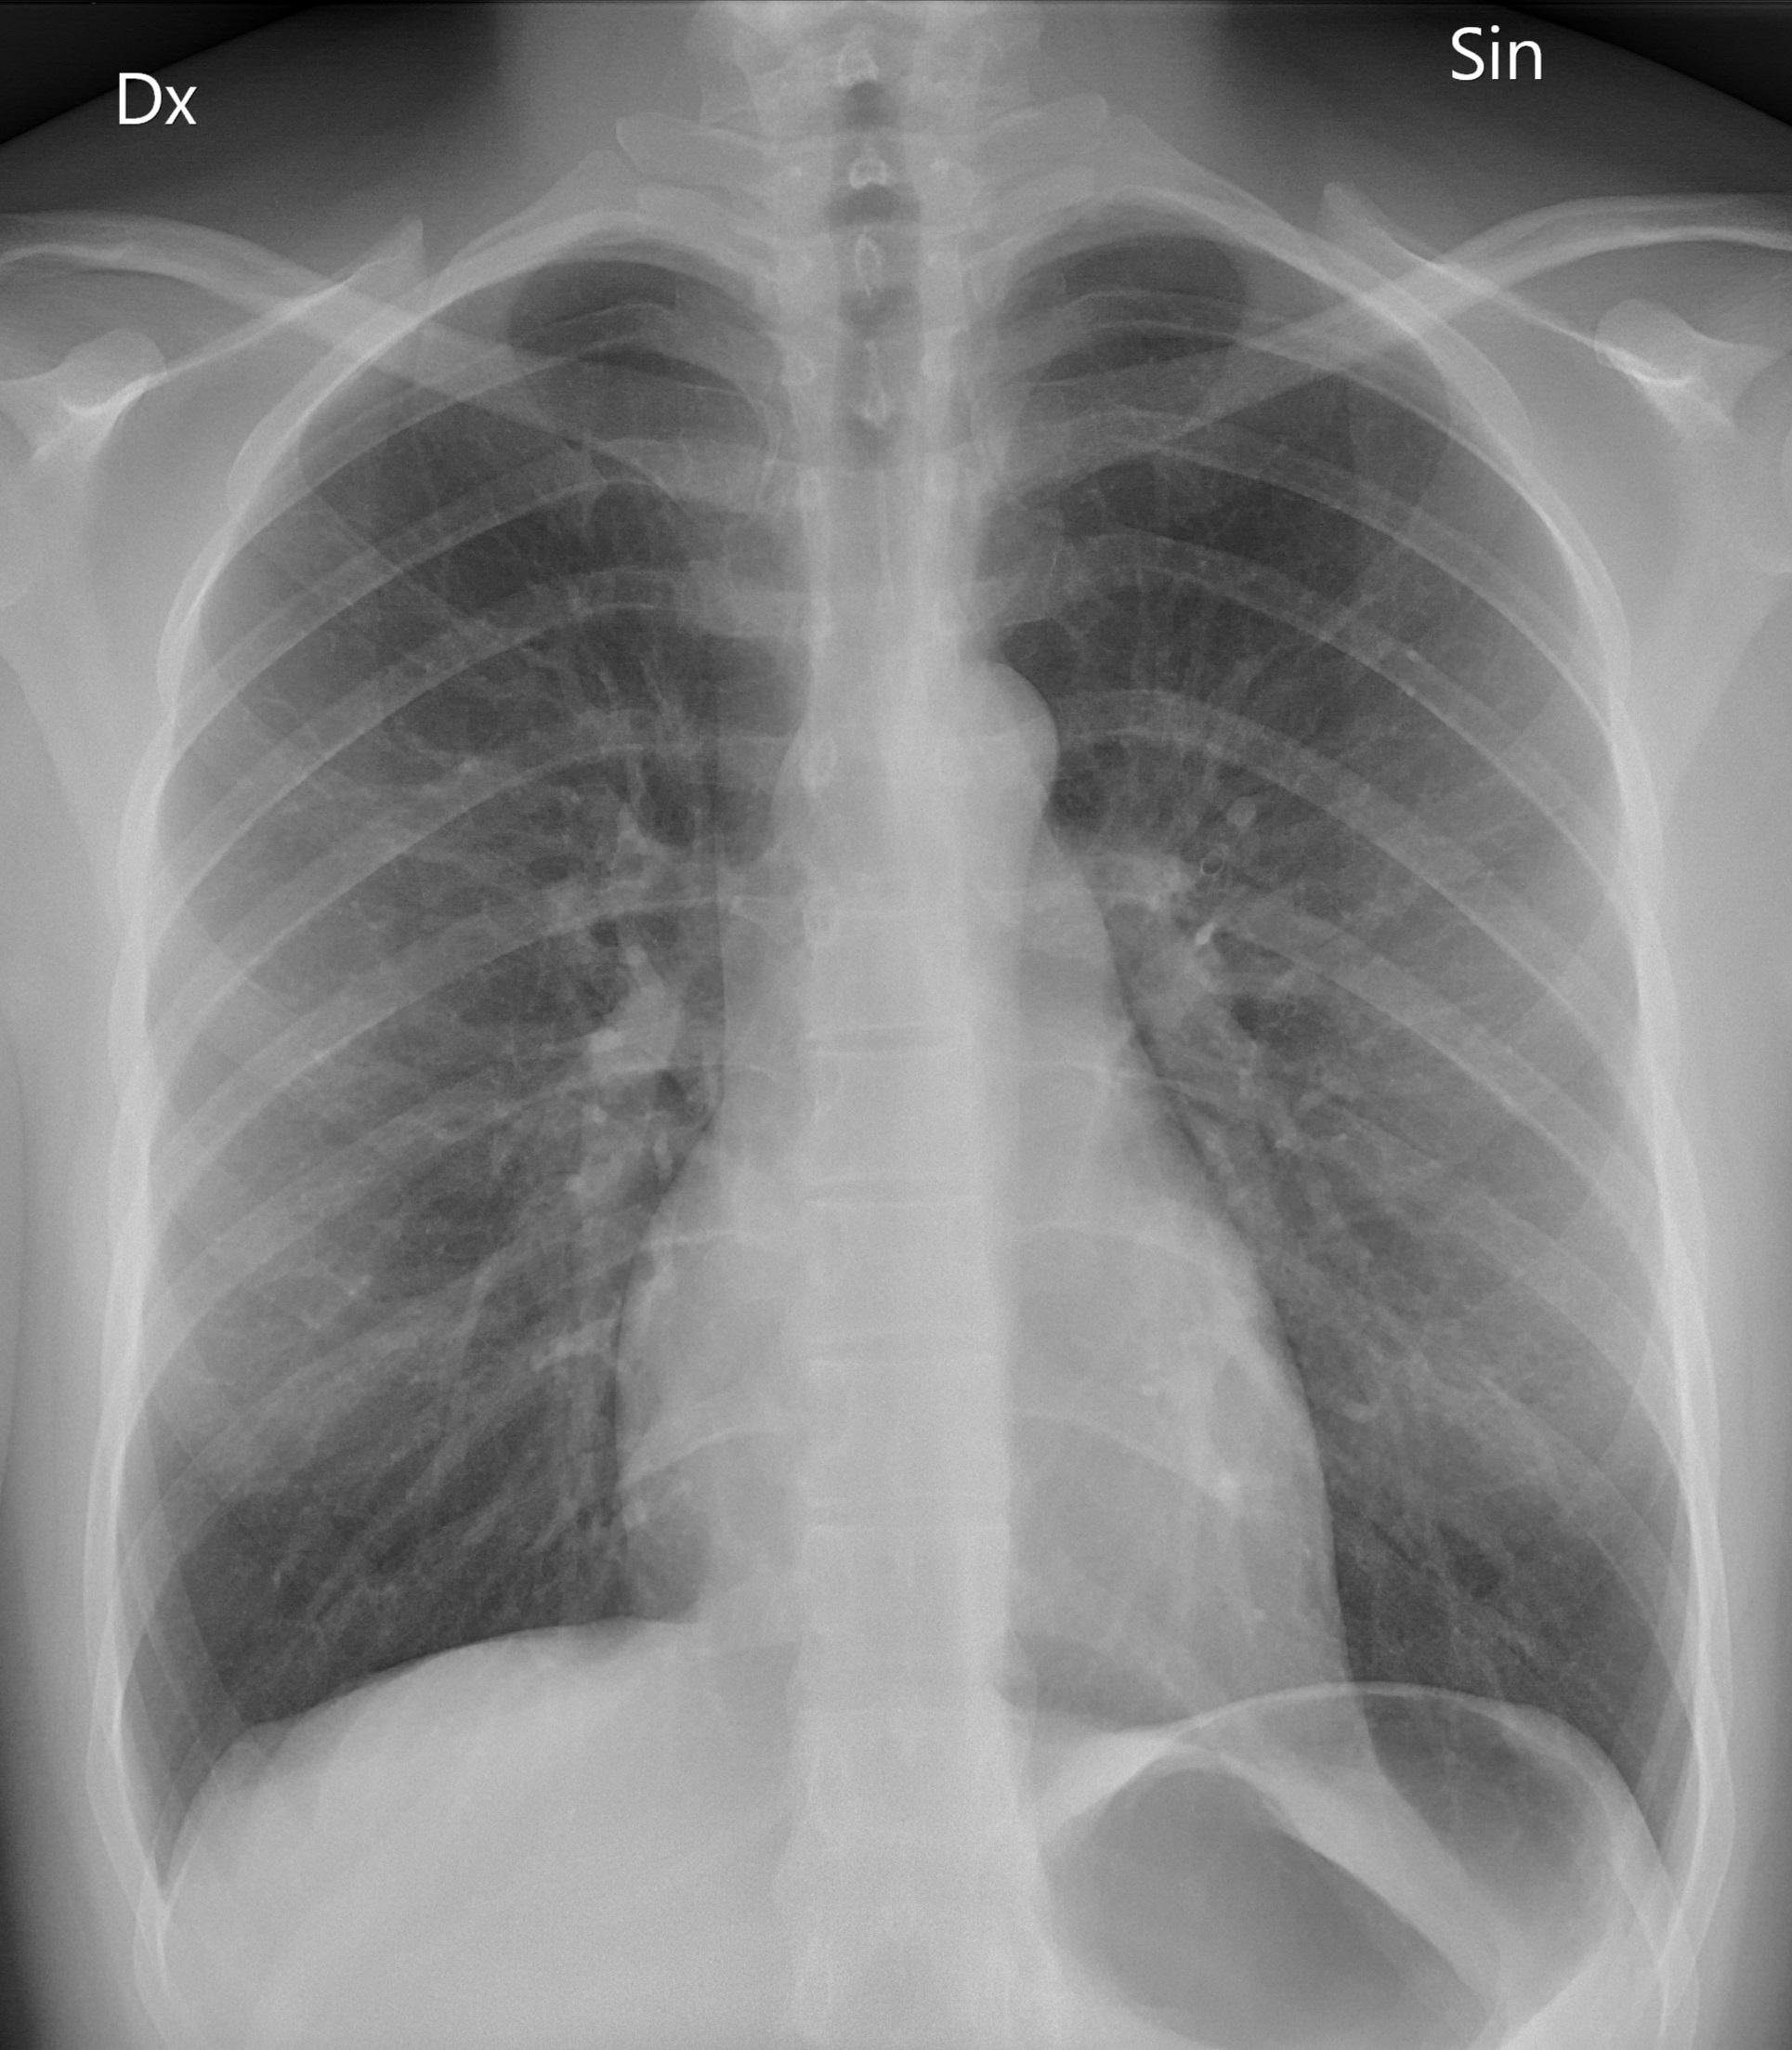
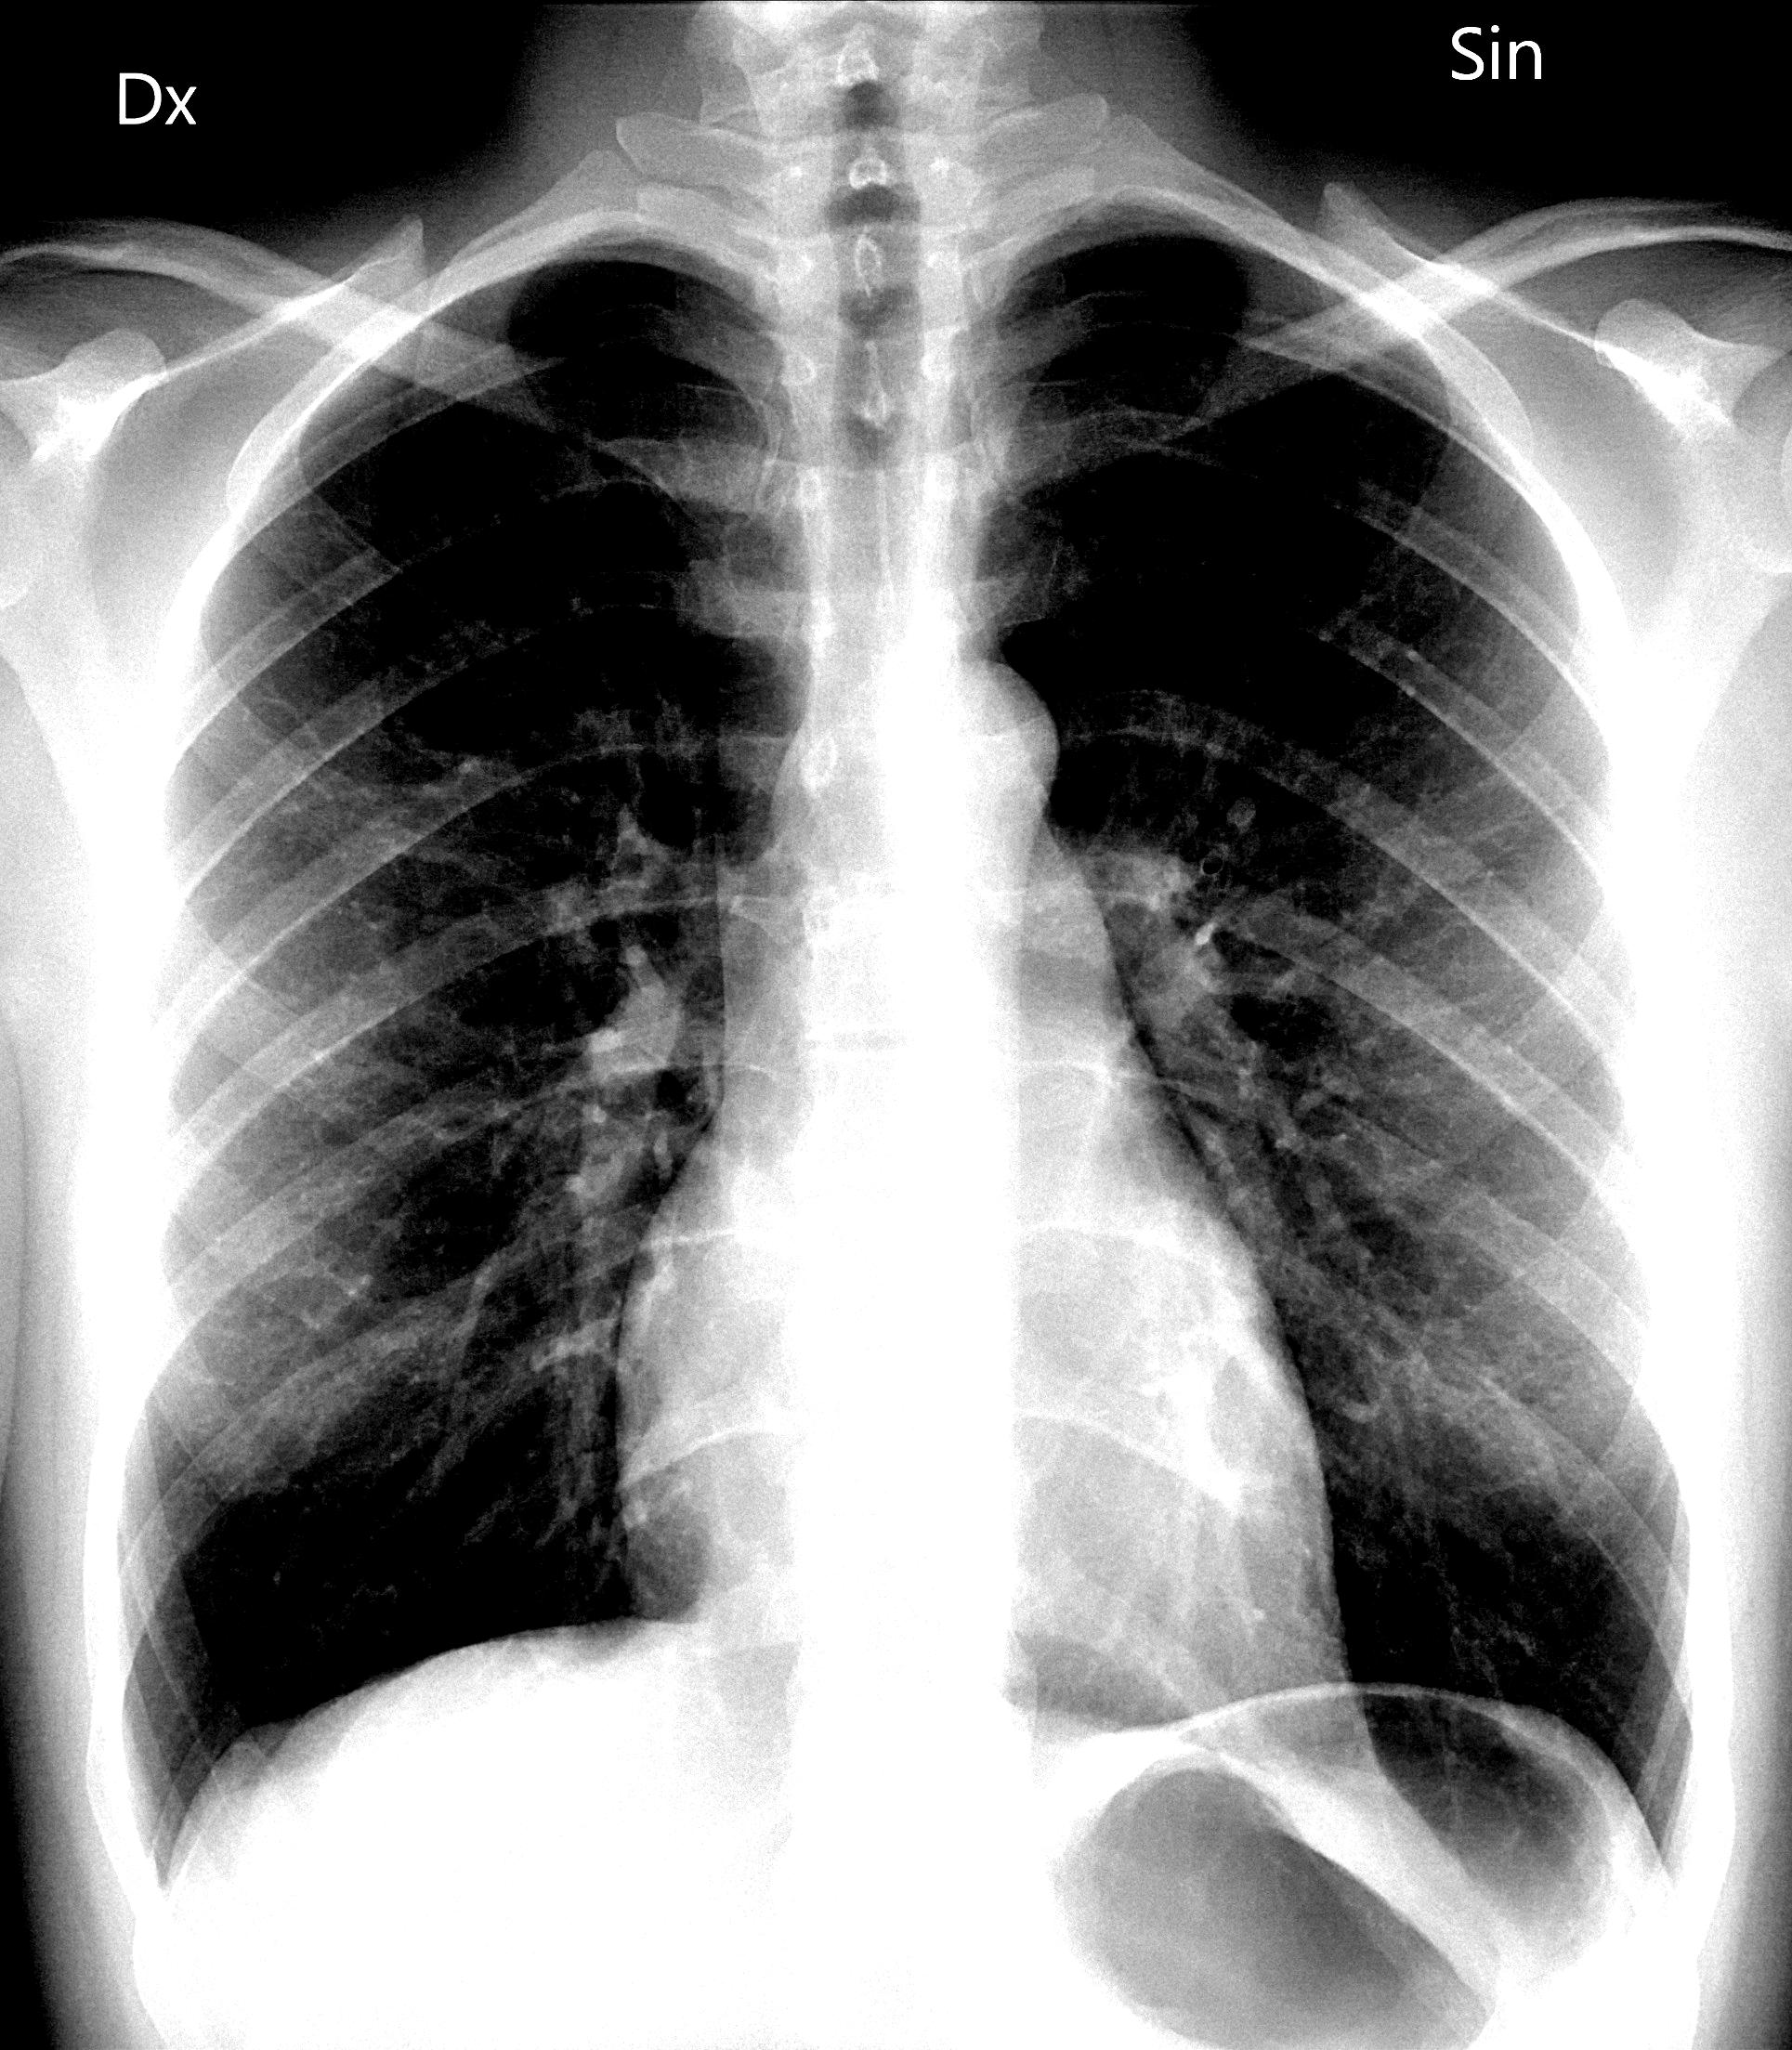
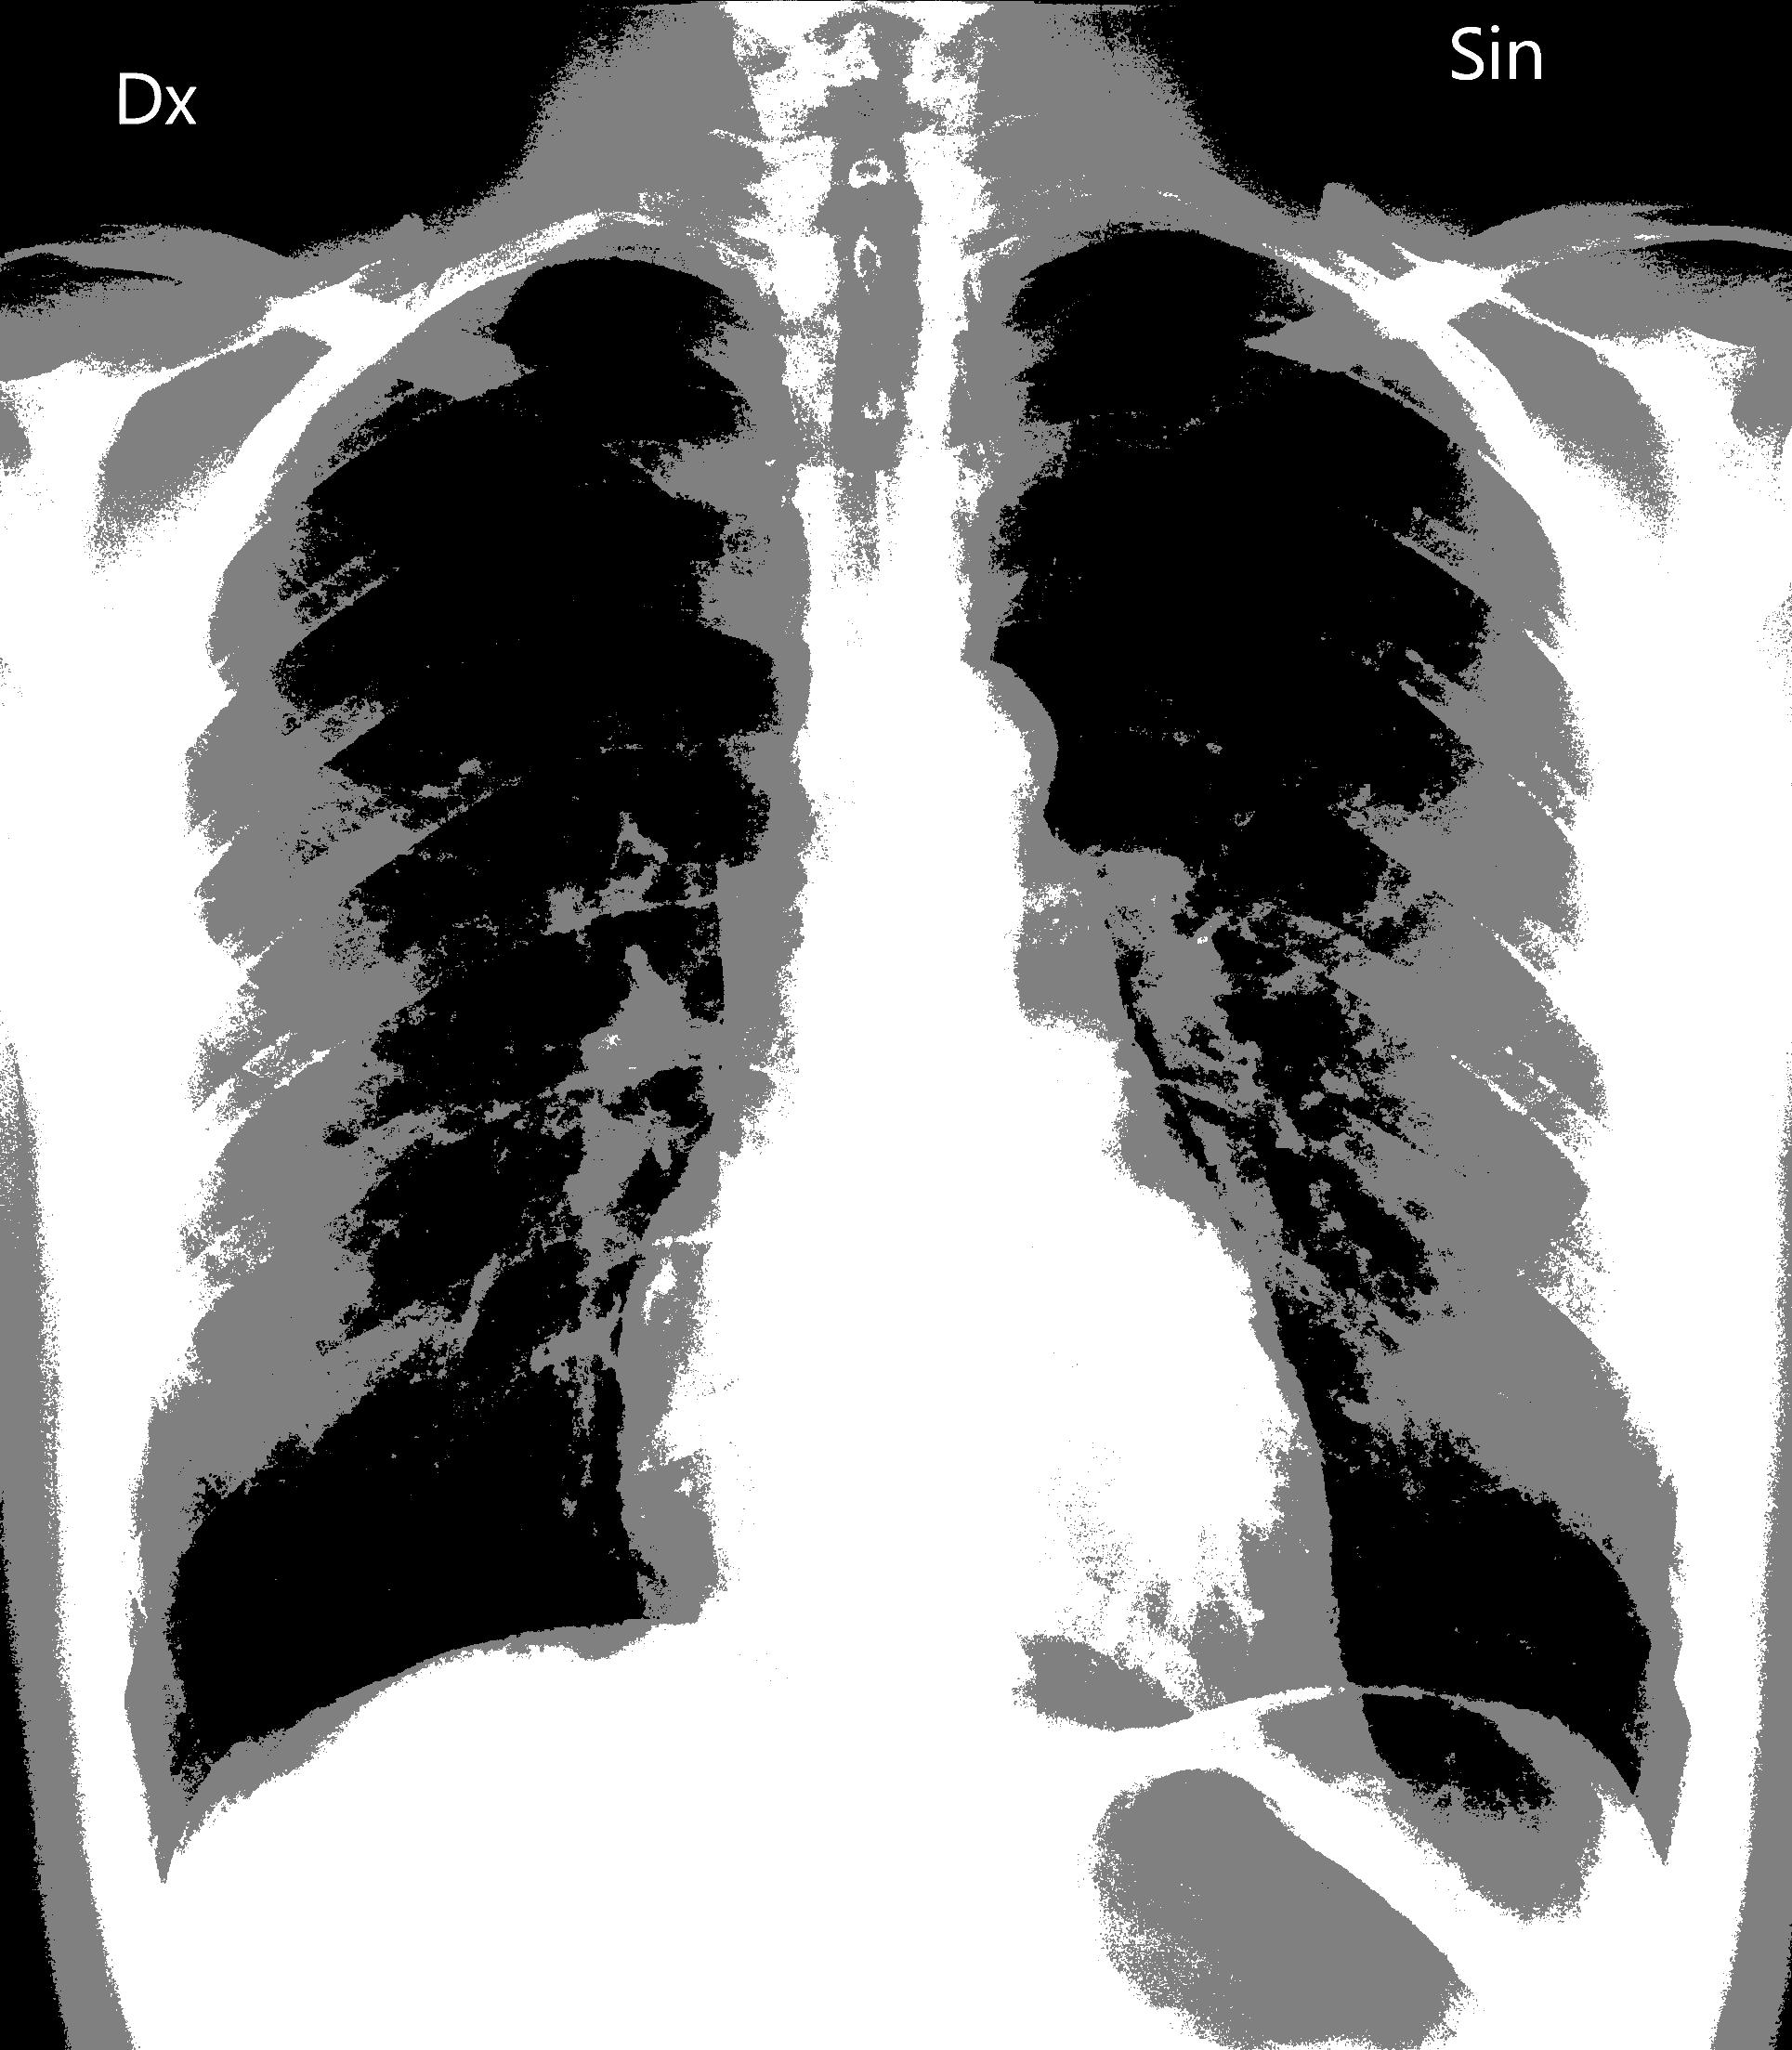
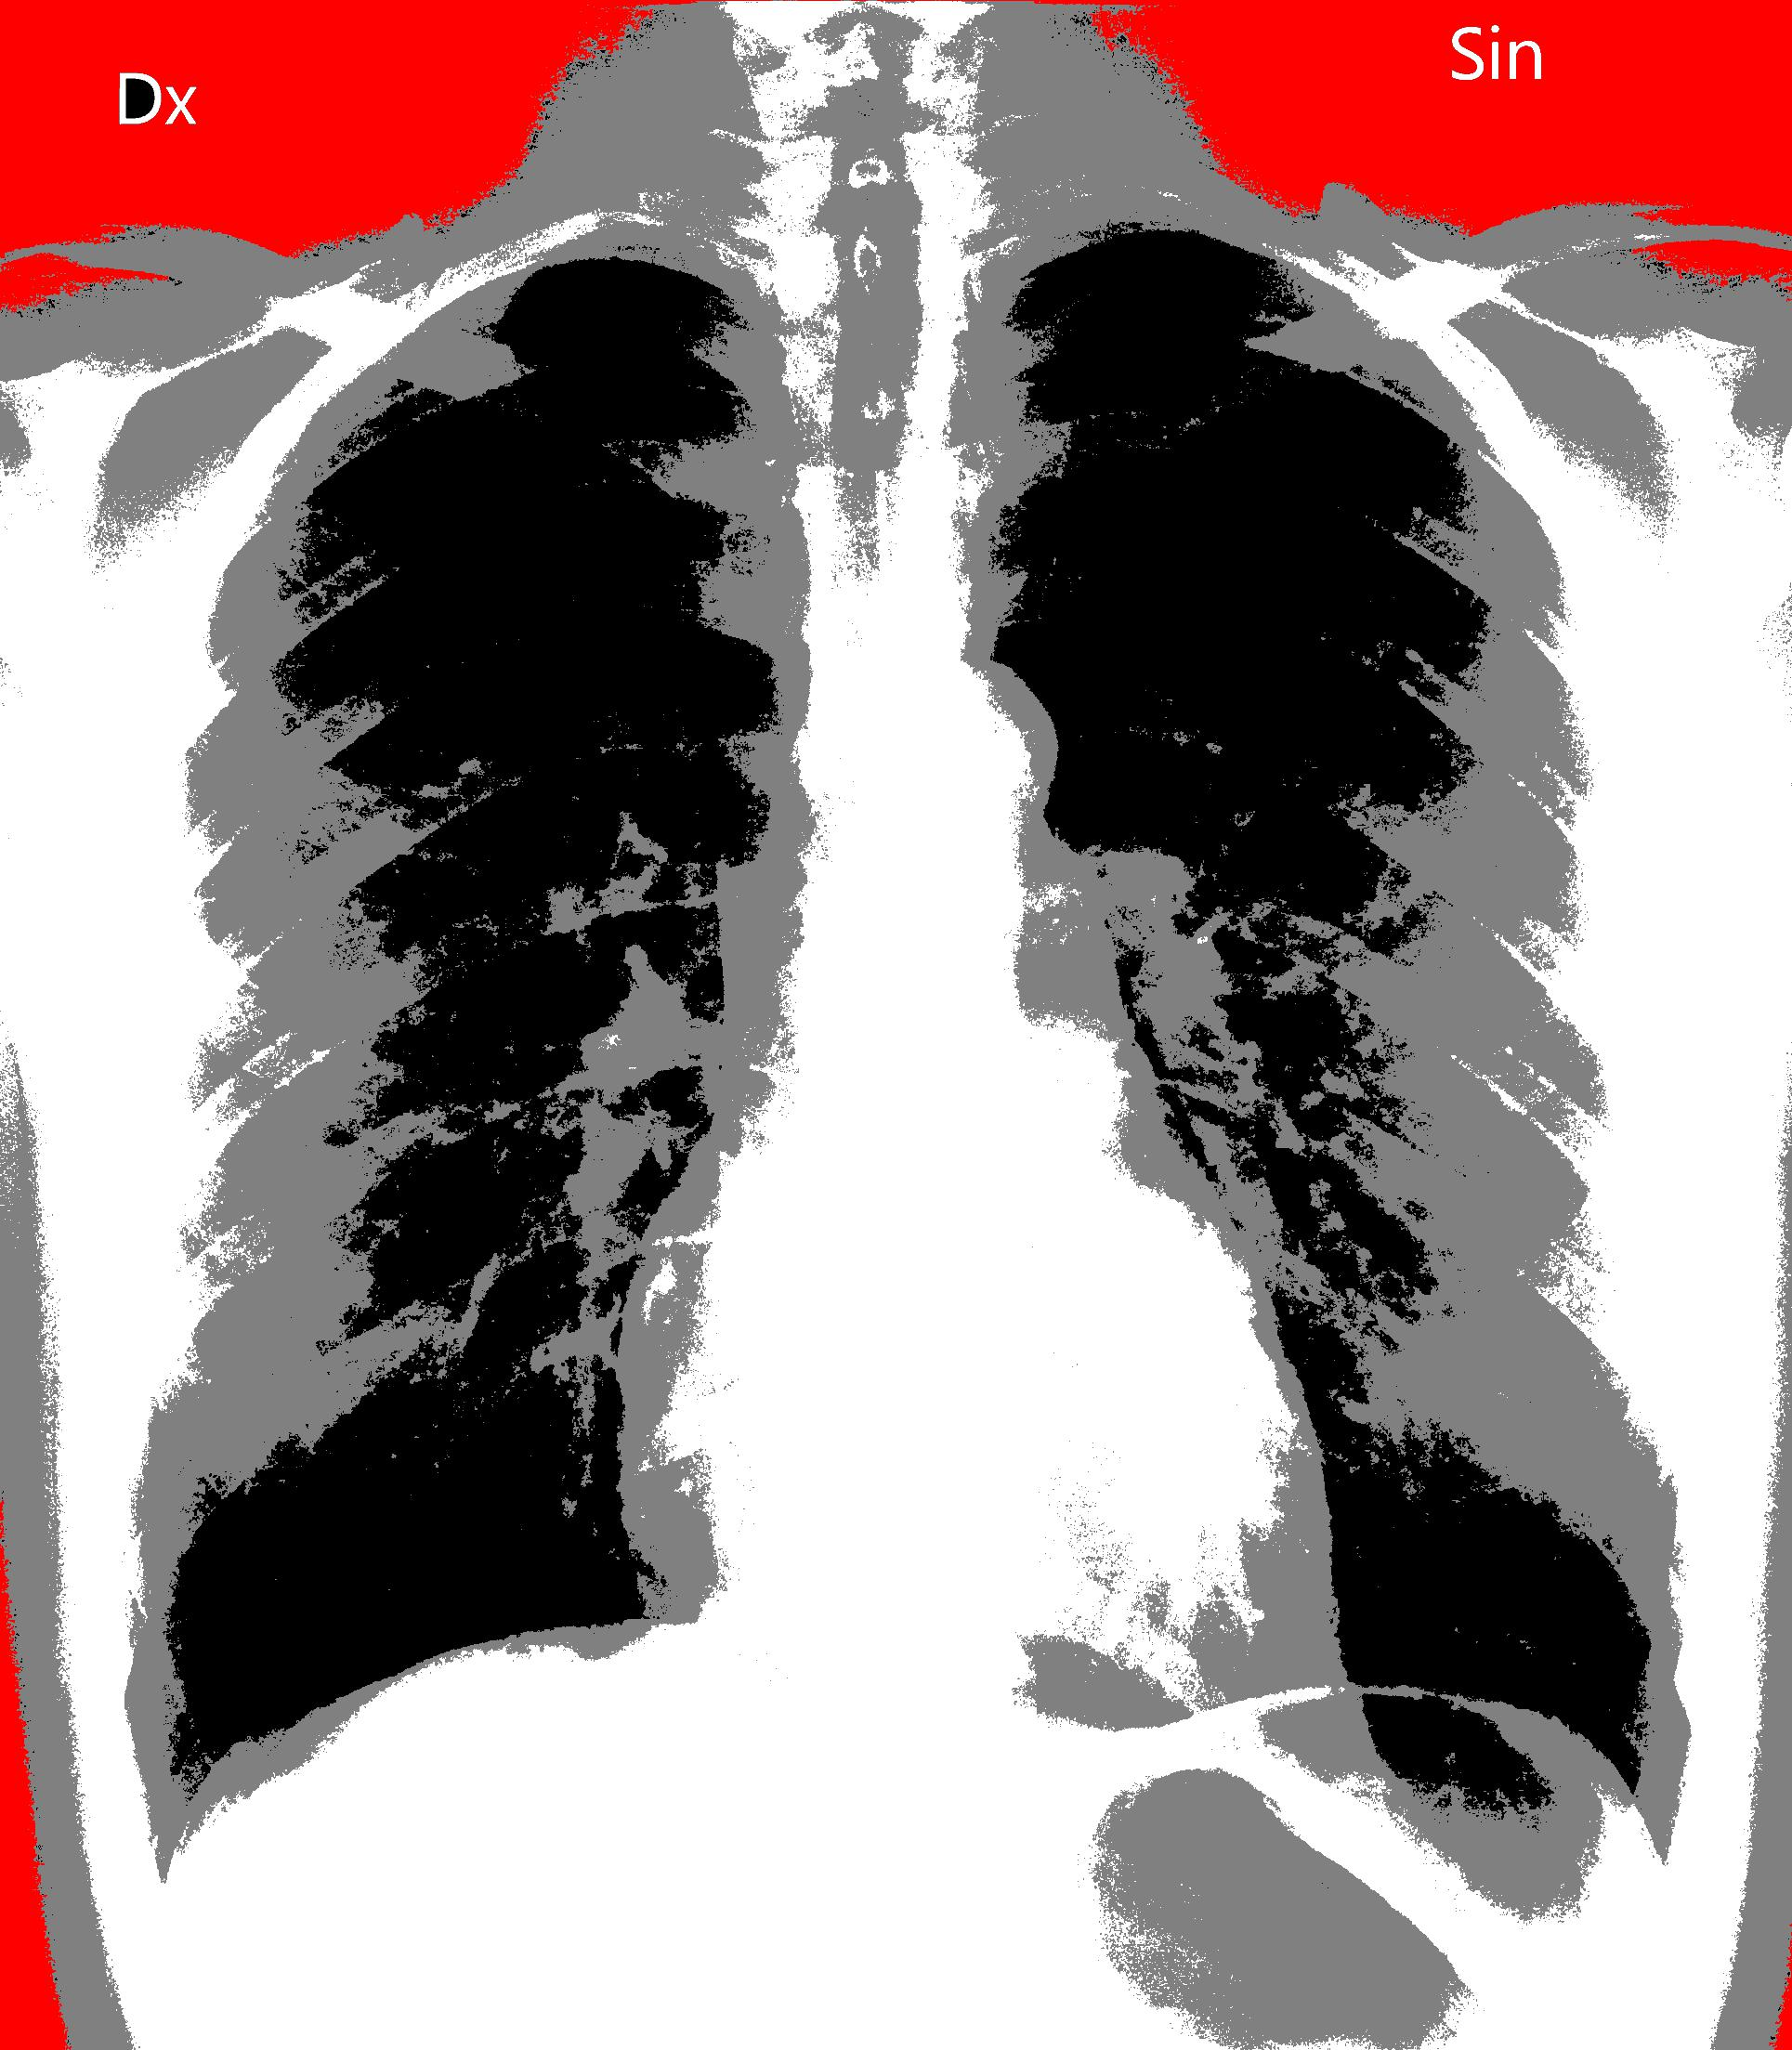

SKLearn model result: NEGATIVE
Custom model result: NEGATIVE

Testing a COVID Positive X-Ray image
{0: 101506, 1: 295781, 2: 1160169} [0.06517423 0.18991291 0.74491286]



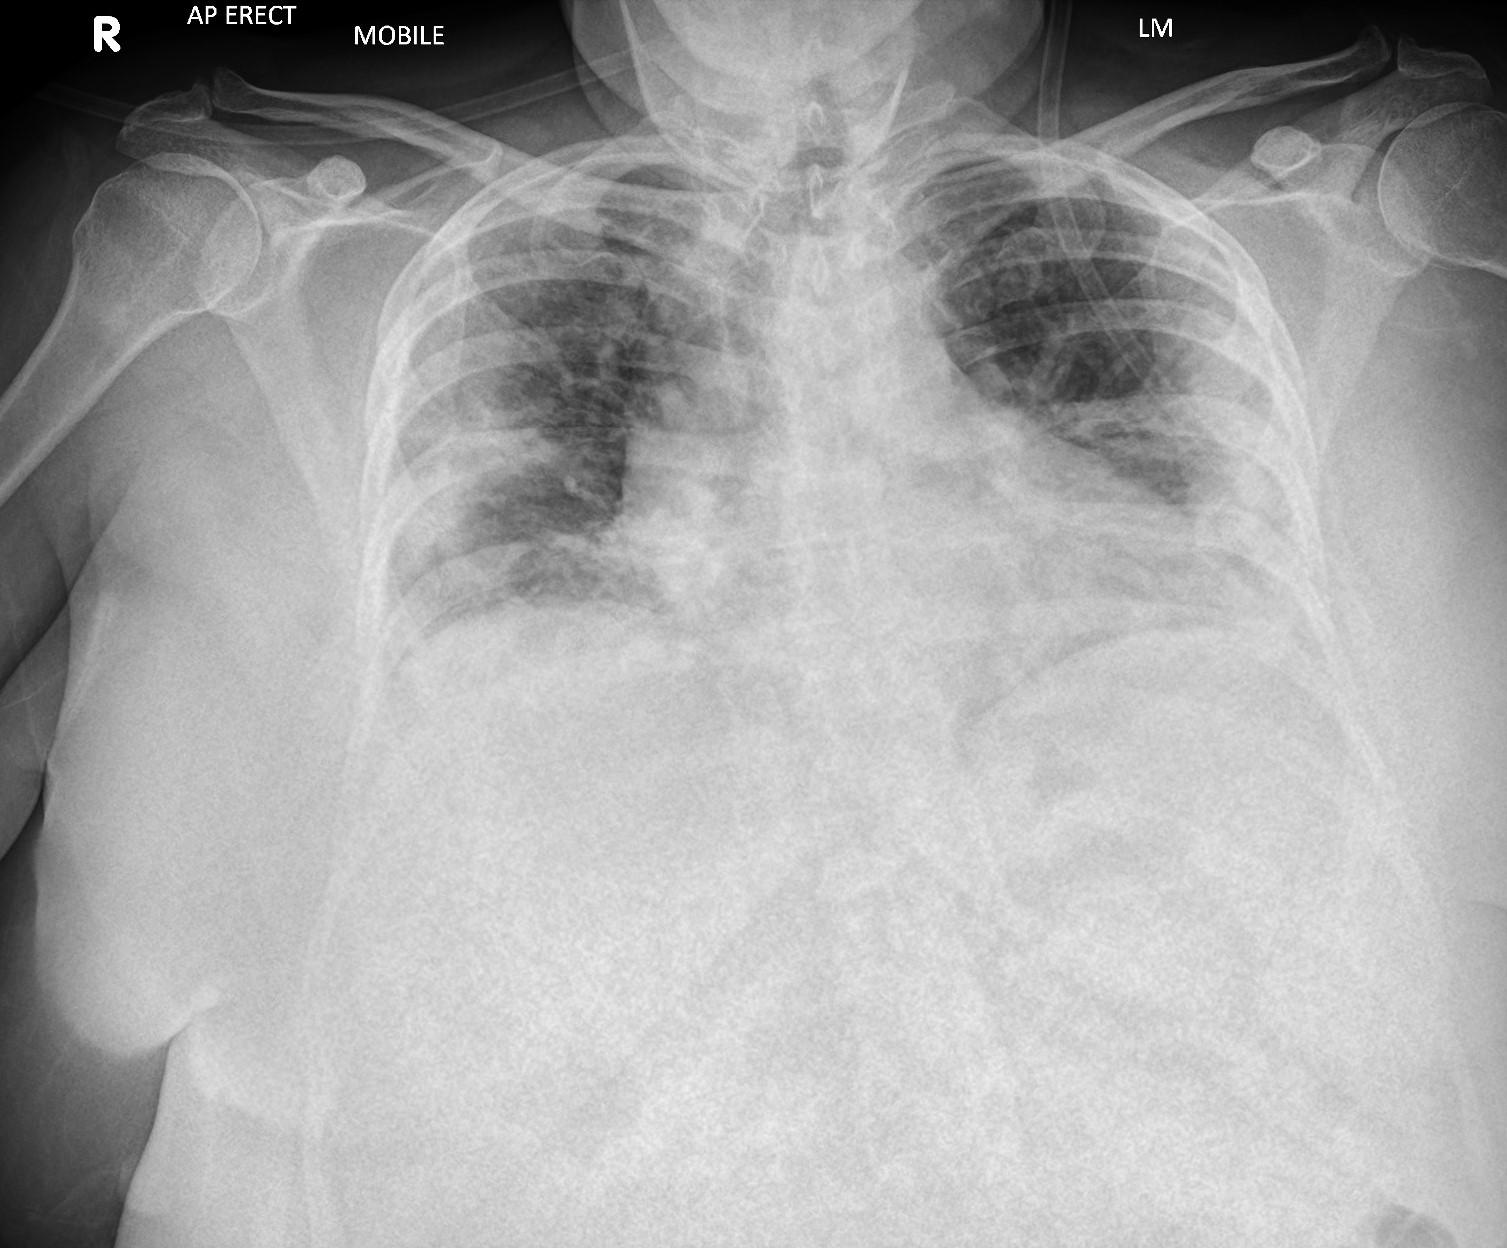
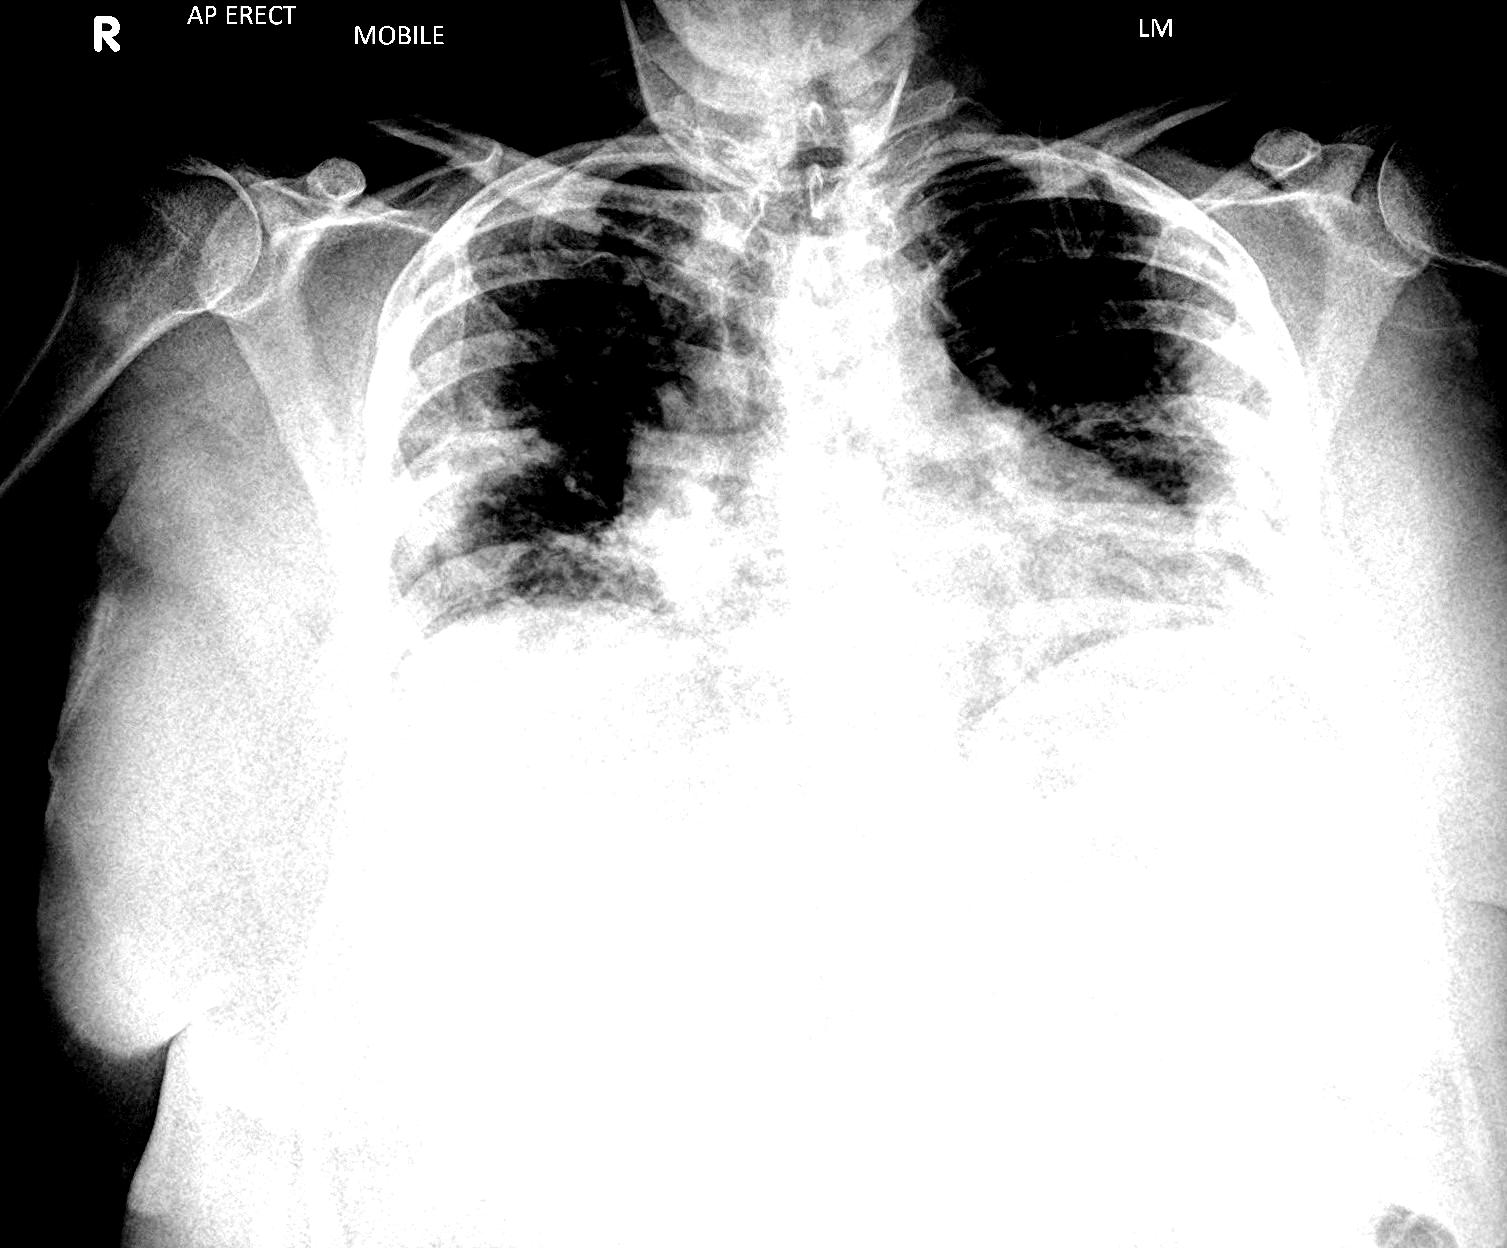
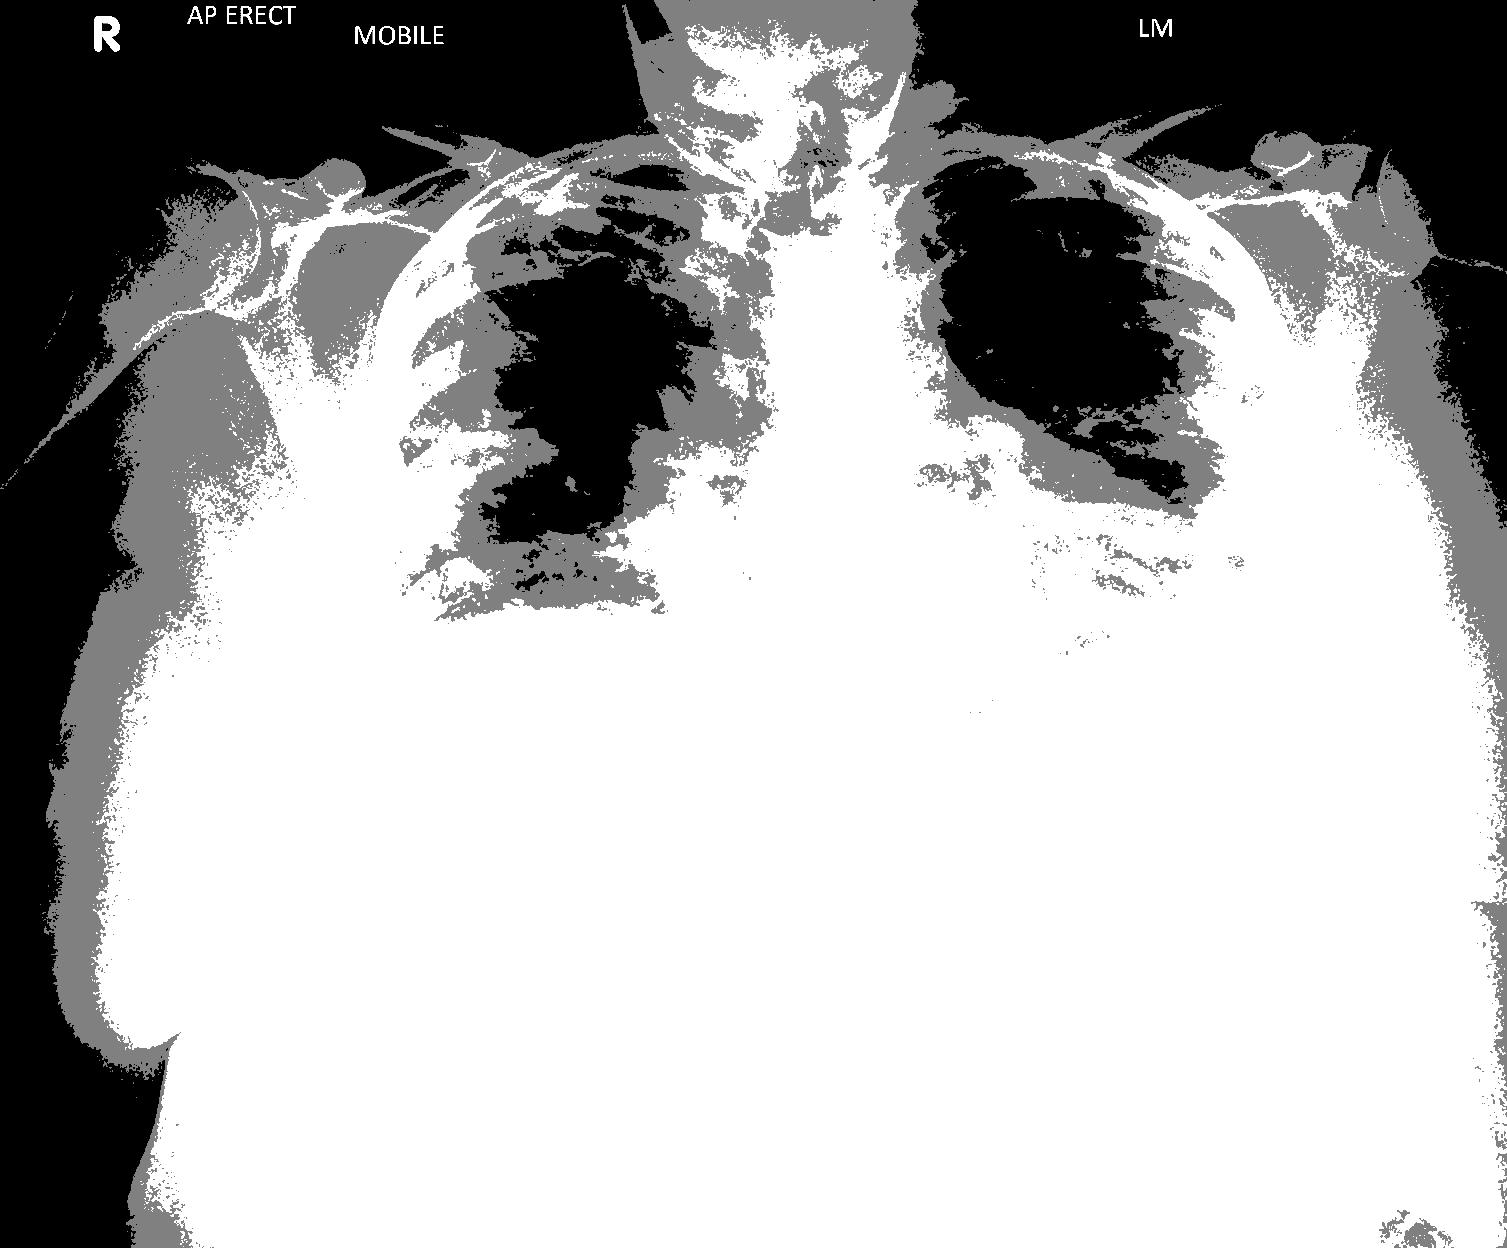
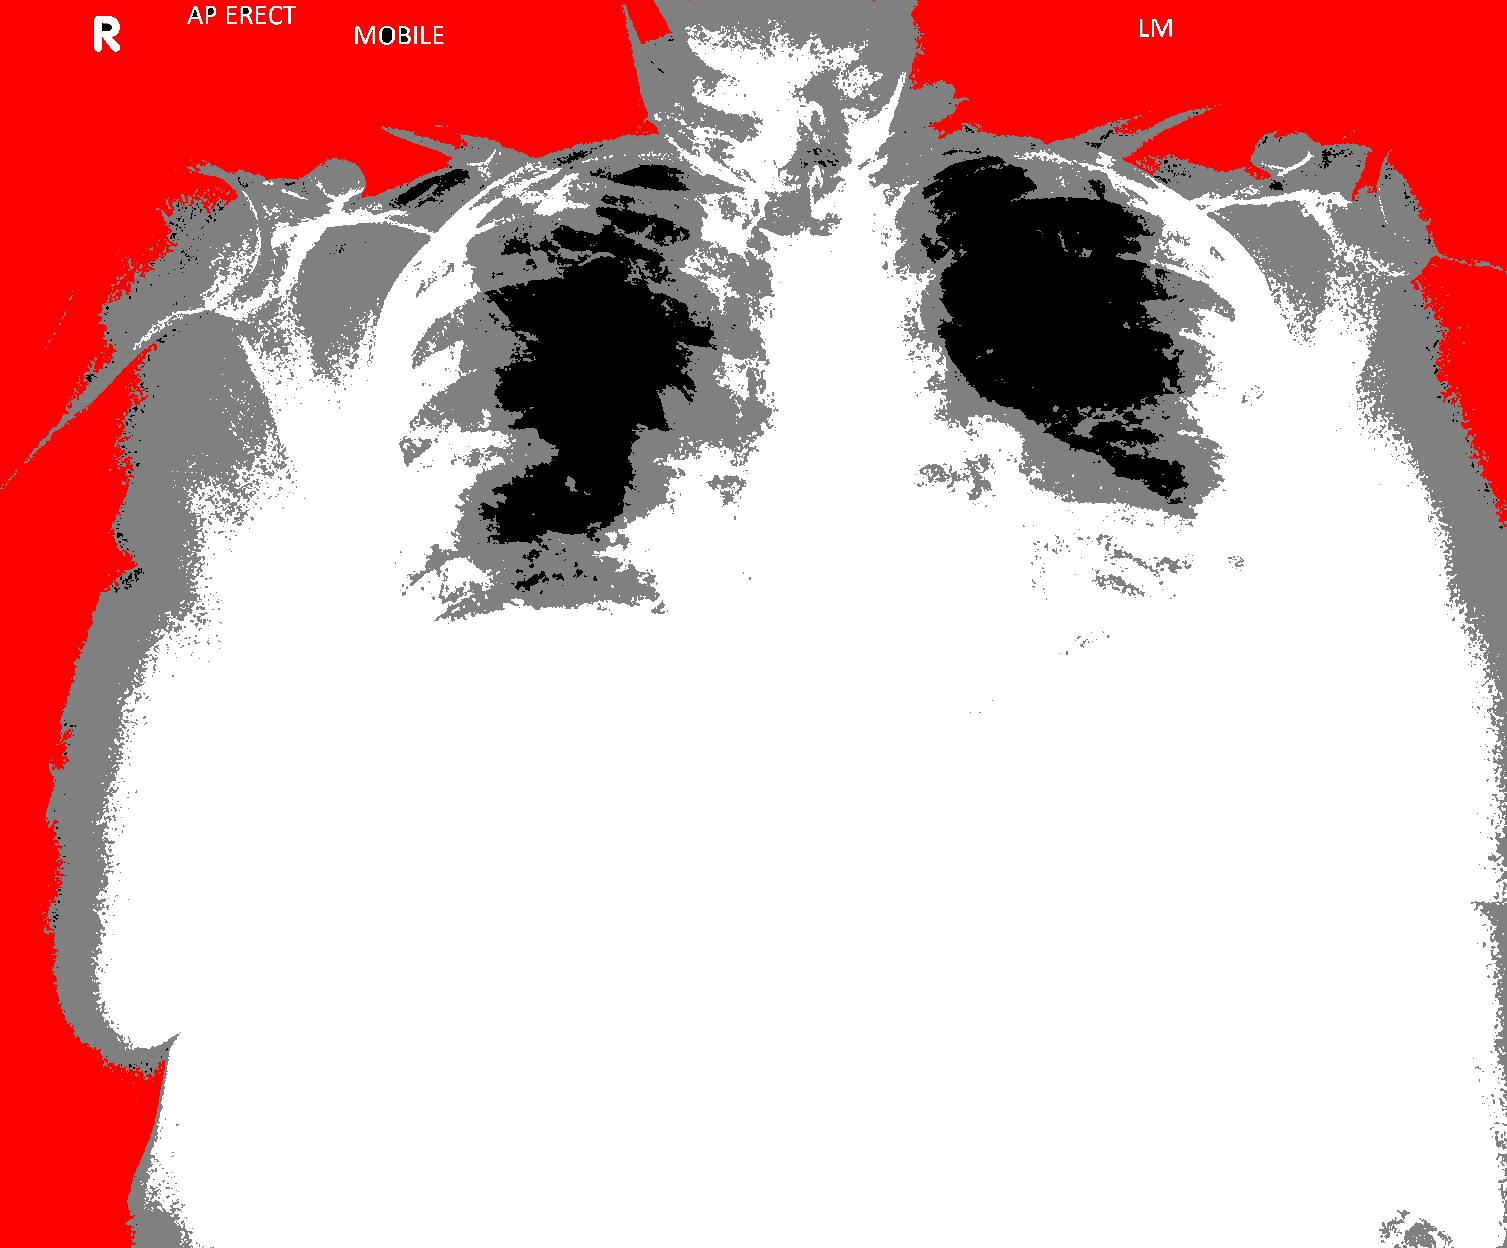

SKLearn model result: POSITIVE
Custom model result: POSITIVE


In [39]:
print('Test with train & test excluded samples')
print('\nTesting a COVID Negative X-Ray image')
predict_from_image('D:/Downloads/normal.jpg', clf, model, ['NEGATIVE', 'POSITIVE'])
print('\nTesting a COVID Positive X-Ray image')
predict_from_image('D:/Downloads/covid.jpg', clf, model, ['NEGATIVE', 'POSITIVE'])